# Importing Libraries

In [175]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats
import math
from sklearn.model_selection import GridSearchCV, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.inspection import permutation_importance

**Removing Unimportant Warnings**

In [176]:
import warnings
from numpy import RankWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RankWarning)

# Reading Data

In [ ]:
df = pd.read_csv('/kaggle/input/first-inten-project/first inten project.csv')

# Data Description

## data Shape

In [178]:
df.head()

,Booking_ID,number of adults,number of children,number of weekend nights,number of week nights,type of meal,car parking space,room type,lead time,market segment type,repeated,P-C,P-not-C,average price,special requests,date of reservation,booking status
0,INN00001,1,1,2,5,Meal Plan 1,0,Room_Type 1,224,Offline,0,0,0,88.00,0,10/2/2015,Not_Canceled
1,INN00002,1,0,1,3,Not Selected,0,Room_Type 1,5,Online,0,0,0,106.68,1,11/6/2018,Not_Canceled
2,INN00003,2,1,1,3,Meal Plan 1,0,Room_Type 1,1,Online,0,0,0,50.00,0,2/28/2018,Canceled
3,INN00004,1,0,0,2,Meal Plan 1,0,Room_Type 1,211,Online,0,0,0,100.00,1,5/20/2017,Canceled
4,INN00005,1,0,1,2,Not Selected,0,Room_Type 1,48,Online,0,0,0,77.00,0,4/11/2018,Canceled


## Features Info

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36285 entries, 0 to 36284
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Booking_ID                36285 non-null  object 
 1   number of adults          36285 non-null  int64  
 2   number of children        36285 non-null  int64  
 3   number of weekend nights  36285 non-null  int64  
 4   number of week nights     36285 non-null  int64  
 5   type of meal              36285 non-null  object 
 6   car parking space         36285 non-null  int64  
 7   room type                 36285 non-null  object 
 8   lead time                 36285 non-null  int64  
 9   market segment type       36285 non-null  object 
 10  repeated                  36285 non-null  int64  
 11  P-C                       36285 non-null  int64  
 12  P-not-C                   36285 non-null  int64  
 13  average price             36285 non-null  float64
 14  specia

## The unique values in non-integer features

In [180]:
for x in ["type of meal", "car parking space", "room type", "market segment type", "booking status"]:
    print(x + ":", df[x].unique())
    print("-" * 100)

type of meal: ['Meal Plan 1' 'Not Selected' 'Meal Plan 2' 'Meal Plan 3']
----------------------------------------------------------------------------------------------------
car parking space: [0 1]
----------------------------------------------------------------------------------------------------
room type: ['Room_Type 1' 'Room_Type 4' 'Room_Type 2' 'Room_Type 6' 'Room_Type 5'
 'Room_Type 7' 'Room_Type 3']
----------------------------------------------------------------------------------------------------
market segment type: ['Offline' 'Online' 'Corporate' 'Aviation' 'Complementary']
----------------------------------------------------------------------------------------------------
booking status: ['Not_Canceled' 'Canceled']
----------------------------------------------------------------------------------------------------


## Features Description

1. **Booking_ID**: A unique identifier for each booking. (Costing Feature)
2. **Number of adults**: The number of adults included in the booking.
3. **Number of children**: The number of children included in the booking.
4. **Number of weekend nights**: The number of weekend nights (Friday and Saturday) included in the booking.
5. **Number of week nights**: The number of weeknights (Sunday to Thursday) included in the booking.
6. **Type of meal**: The type of meal plan chosen for the booking. (plan 1/2/3)
7. **Car parking space**: Car parking space requested or not.
8. **Room type**: The type of room booked. (type [1 - 7])
9. **Lead time**: The number of days between the booking date and the check-in date.
10. **Market segment type**: The market segment from which the booking originated, such as ['Offline' 'Online' 'Corporate' 'Aviation' 'Complementary'].
11. **Repeated**: Indicator of whether the booking is from a repeat guest.
12. **P-C**: The number of previous booking cancellation.
13. **P-not-C**: The number of previous non-cancellations.
14. **Average price**: The average price per night for the booking.
15. **Special requests**: The number of special requests made by the guest for the booking.
16. **Date of reservation**: The date when the reservation was made.
17. **Booking status**: The current status of the booking, such as ['Not_Canceled' 'Canceled'].

## Number of duplicates

In [181]:
print("Number of duplicates =", df.duplicated().sum())

Number of duplicates = 0


## summary
**The dataset have:**
- No Nulls.
- No Duplicates.
- Costing features which should be removed: (Booking_ID).
- Features should be encoded: (type of meal, room type, market segment type, booking status).
- new features: (family_size, total_nights, reservation_year, reservation_month, reservation_day, Previous Reservations, Cancellation Per Reservation)

# Data Preprocessing

## Removing Costing Features

In [182]:
def drop_costing_features(df):
    df.drop('Booking_ID', axis = 1, inplace = True)

## Encoding

- Features (**type of meal, room type**) have ordered values, so Ordinal Encoding encoding should be used.
- **market segment type** feature has unordered values, so label encoding should be used.
- **booking status** should be encoded using binary encoding

In [183]:
def Encoding(df):
    df['type_of_meal_encoded'] = [0 if x == 'Not Selected' else int( x.replace('Meal Plan ', '')) for x in df['type of meal']]
    df['room_type_encoded'] = [int( x.replace('Room_Type ', '')) for x in df['room type']]
    df['market_segment_type_encoded'] = LabelEncoder().fit_transform(df['market segment type'])
    df['booking_status_encoded'] = [1 if x == 'Canceled' else 0 for x in df['booking status']]

## Feature Engineering (Adding New Features)

In [184]:
def new_features(df):
    df.insert(df.columns.get_loc('number of children') + 1, 'family_size', df['number of adults'] + df['number of children'])

    df.insert(df.columns.get_loc('number of week nights') + 1, 'total_nights', df['number of weekend nights'] + df['number of week nights'])

    df.insert(df.columns.get_loc('P-not-C') + 1, 'pre_reserv', df['P-C'] + df['P-not-C'])
    df.insert(df.columns.get_loc('pre_reserv') + 1, 'c_per_reserv', df['P-C'] / df['pre_reserv'] * 100) #the division by zero will generate nulls 
    df.fillna({'c_per_reserv': 0}, inplace=True)  #replace generated nulls with 0

    df['date_new_form'] = [[3, 1, 2018] if date == '2018-2-29' else date.split(sep='/') if '/' in date else date.split(sep='-') for date in df['date of reservation']]
    df['reservation_day'] = [int(x[1]) for x in df['date_new_form']]
    df['reservation_month'] = [int(x[0]) for x in df['date_new_form']]
    df['reservation_year'] = [int(x[2]) for x in df['date_new_form']]
    df.drop(['date_new_form', 'date of reservation'], axis=1, inplace=True)

## Preprocessing Function

In [185]:
def preprocessing(df):
    drop_costing_features(df)
    Encoding(df)
    new_features(df)

preprocessing(df)

# Data Statistics

In [186]:
df.describe()

,number of adults,number of children,family_size,number of weekend nights,number of week nights,total_nights,car parking space,lead time,repeated,P-C,...,c_per_reserv,average price,special requests,type_of_meal_encoded,room_type_encoded,market_segment_type_encoded,booking_status_encoded,reservation_day,reservation_month,reservation_year
count,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,...,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000
mean,1.844839,0.105360,1.950200,0.810693,2.204602,3.015296,0.030977,85.239851,0.025630,0.023343,...,0.476201,103.421636,0.619733,0.949952,1.708860,3.552487,0.327656,15.568141,7.424831,2017.820284
std,0.518813,0.402704,0.650361,0.870590,1.410946,1.786000,0.173258,85.938796,0.158032,0.368281,...,6.215914,35.086469,0.786262,0.480209,1.399801,0.681489,0.469365,8.742225,3.068299,0.384243
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,2015.000000
25%,2.000000,0.000000,2.000000,0.000000,1.000000,2.000000,0.000000,17.000000,0.000000,0.000000,...,0.000000,80.300000,0.000000,1.000000,1.000000,3.000000,0.000000,8.000000,5.000000,2018.000000
50%,2.000000,0.000000,2.000000,1.000000,2.000000,3.000000,0.000000,57.000000,0.000000,0.000000,...,0.000000,99.450000,0.000000,1.000000,1.000000,4.000000,0.000000,16.000000,8.000000,2018.000000
75%,2.000000,0.000000,2.000000,2.000000,3.000000,4.000000,0.000000,126.000000,0.000000,0.000000,...,0.000000,120.000000,1.000000,1.000000,1.000000,4.000000,1.000000,23.000000,10.000000,2018.000000
max,4.000000,10.000000,12.000000,7.000000,17.000000,24.000000,1.000000,443.000000,1.000000,13.000000,...,100.000000,540.000000,5.000000,3.000000,7.000000,4.000000,1.000000,31.000000,12.000000,2018.000000


## The free reservations

In [187]:
print(df[df['average price '] == 0]['market segment type'].value_counts())

market segment type
Complementary    354
Online           191
Name: count, dtype: int64


### Free Complementary Reservations

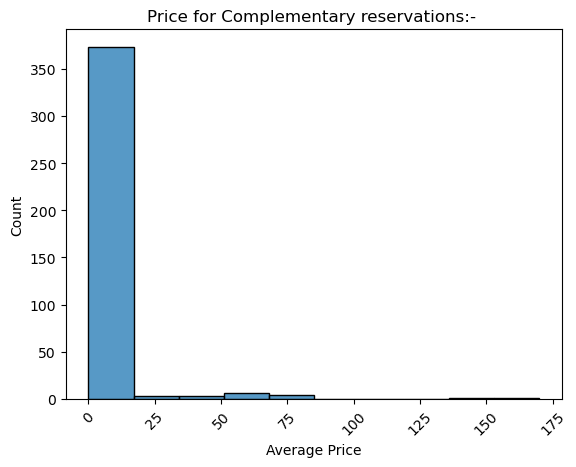

In [188]:
plt.figure()
sns.histplot(df[df['market segment type'] == 'Complementary']['average price '])
plt.title("Price for Complementary reservations:- ")
plt.xlabel("Average Price")
plt.xticks(rotation = 45)
plt.ylabel('Count')
plt.show()

**Most of Complementary reservations are free**

## Reservations with zero total nights

In [189]:
display(df[df['total_nights'] == 0]['average price '].value_counts())

average price 
0.0    78
Name: count, dtype: int64

**All are free of charge, possibly they are advertisement trips.**

# Data Visualization

**Divide columns into numerical and categorical**

In [190]:
numerical_columns = df.select_dtypes(['int64', 'float64']).columns
numerical_columns = [x for x in numerical_columns if 'encoded' not in x and x not in ['car parking space', 'repeated']]

categorical_columns = [x for x in df.columns if x not in numerical_columns]

## Features Distribution

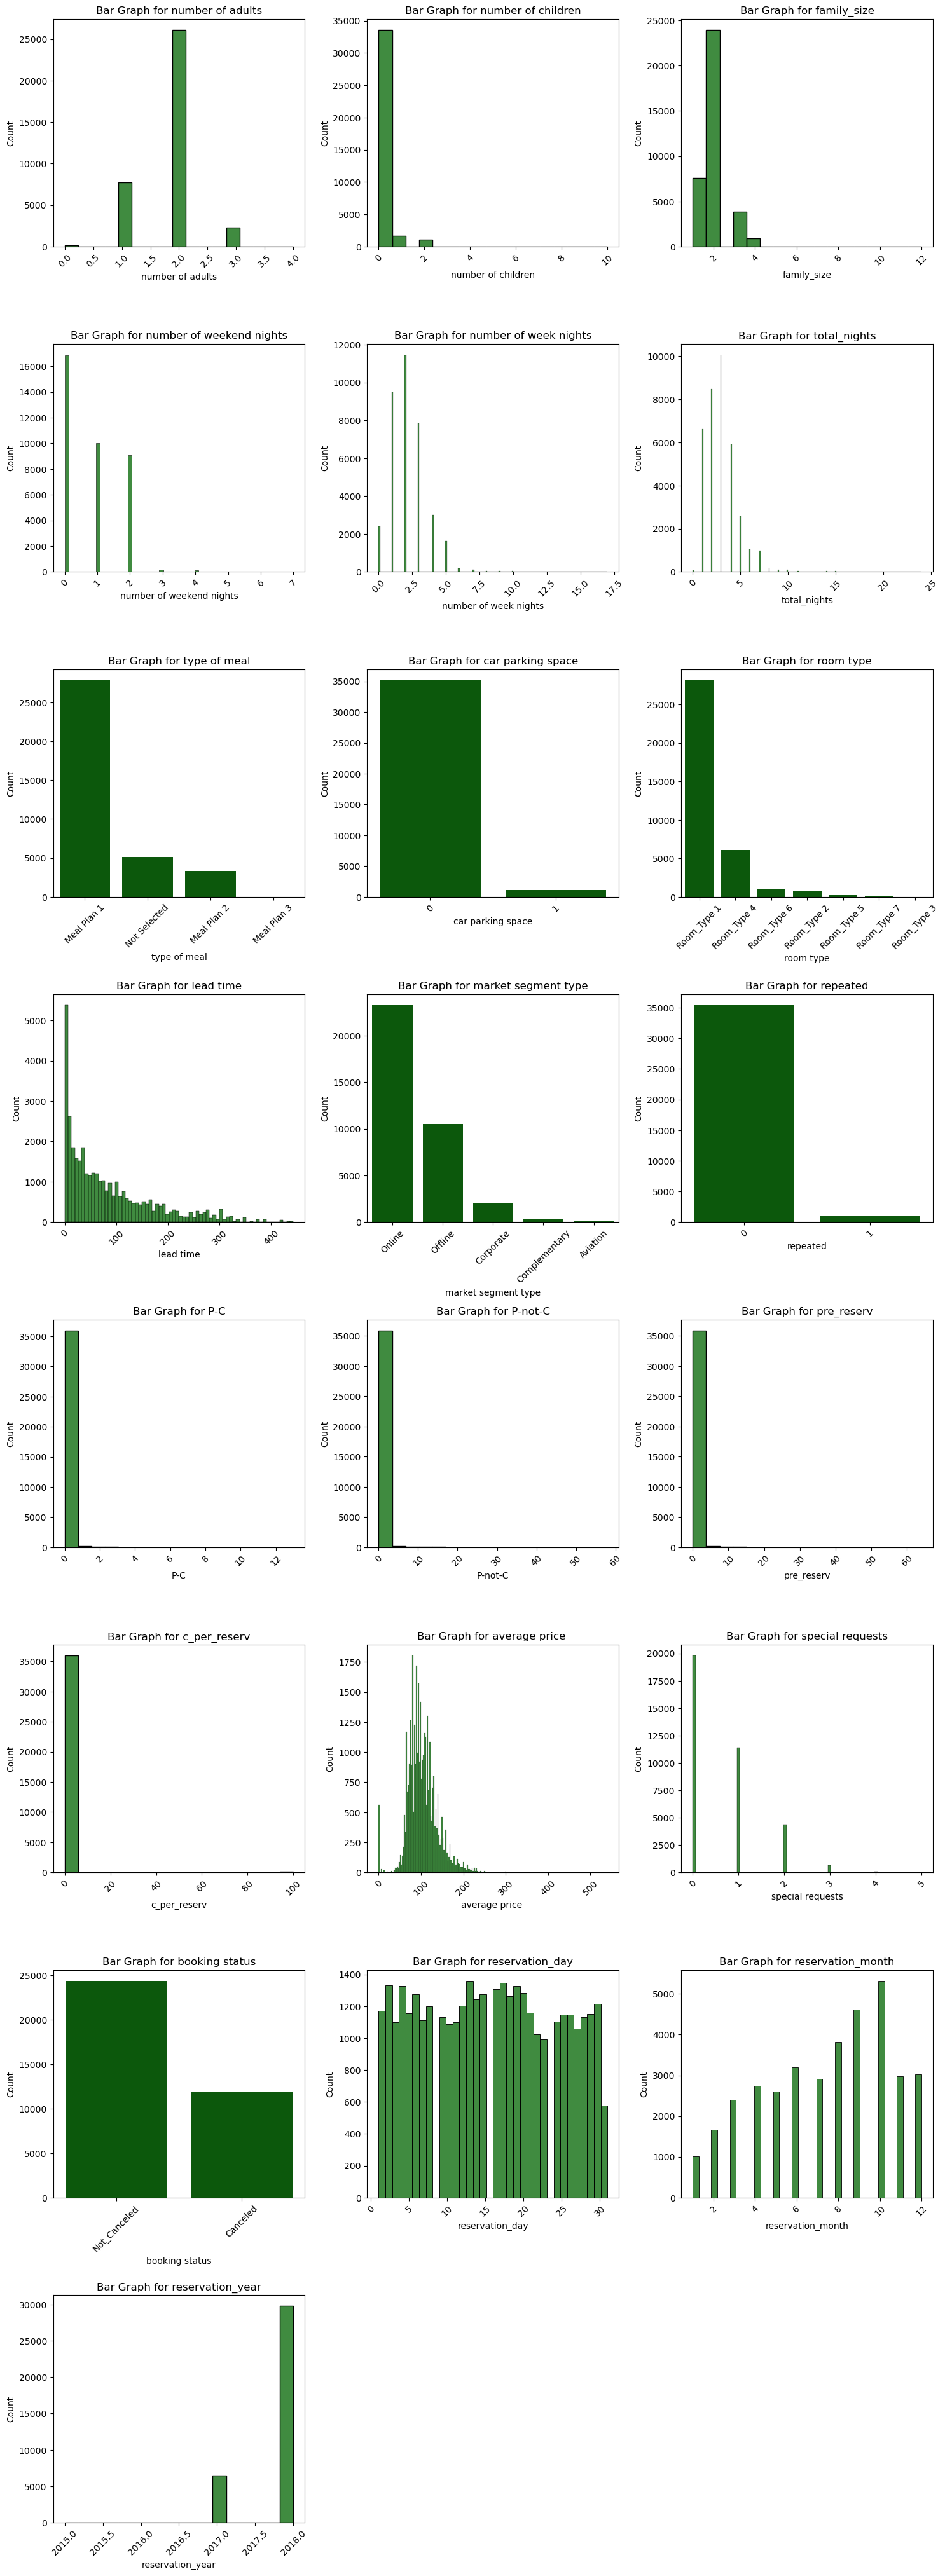

In [191]:
x = 0
rows = math.ceil(len(df.columns) / 3.0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

for column in df.columns:
    if "encoded" in column:
        continue
    
    if column in numerical_columns:
        sns.histplot(ax=axes[x], x=df[column], color= '#006400')
    else:
        sns.barplot(ax=axes[x], x=df[column].value_counts().index, y=df[column].value_counts().values, color= '#006400')
    
    axes[x].set_title("Bar Graph for " + column)
    axes[x].set_xlabel(column)
    for label in axes[x].get_xticklabels():
        label.set_rotation(45)
    axes[x].set_ylabel('Count')
    x += 1

for i in range(x, len(axes)):
    fig.delaxes(axes[i])
    
plt.tight_layout()
plt.show()

**Summary:**

- **Number of Adults**: The most common is 2 adults, followed by 1.
- **Number of Children**: Most entries are likely to have fewer children.
- **Family Size**: Majority is 4 or less, with the most being 2.

- **Number of Weekend Nights**: Most entries tend to have fewer weekend nights.
- **Number of Week Nights**: Entries are likely to have fewer weeknights and are normally distributed around 2.5.
- **Total Nights**: Majority is 10 or less and is normally distributed around 3.

- **Type of Meal**: Occurrences in descending order are ["Meal Plan 1", "Not Selected", "Meal Plan 2", "Meal Plan 3"].
- **Car Parking Space**: Most entries did not request a car parking space.
- **Room Type**: The most common is type 1, followed by type 4.
- **Lead Time**: Majority of reservations have shorter lead times.
- **Market Segment Type**: - Occurrences in descending order are ["Online", "Offline", "Corporate", "Complementary", "Aviation"]
                           - implying the prevalence of remote reservation platform.
- **Repeated**: Vast majority of entries are new guests, which could imply good marketing or that old guests did not enjoy the service.
- **P-C** & **P-not-C** & **p_reserv** & **C_Per_Reserv**: Majority of data points are concentrated at the value 0, possibly because most entries are new guests.
- **Average Price**: Prices are normally distributed with a mean of 103.
- **Special Requests**: Most entries prefer fewer special requests.
- **Booking Status**: Most bookings are not canceled, implying good service. "Imbalanced Data"
- **Reservation Month**: Most entries are reserved in August, September, and October, preferring the later months but before November.
- **Reservation Year**: Most common year is 2018, followed by 2017.


## Correlation between features

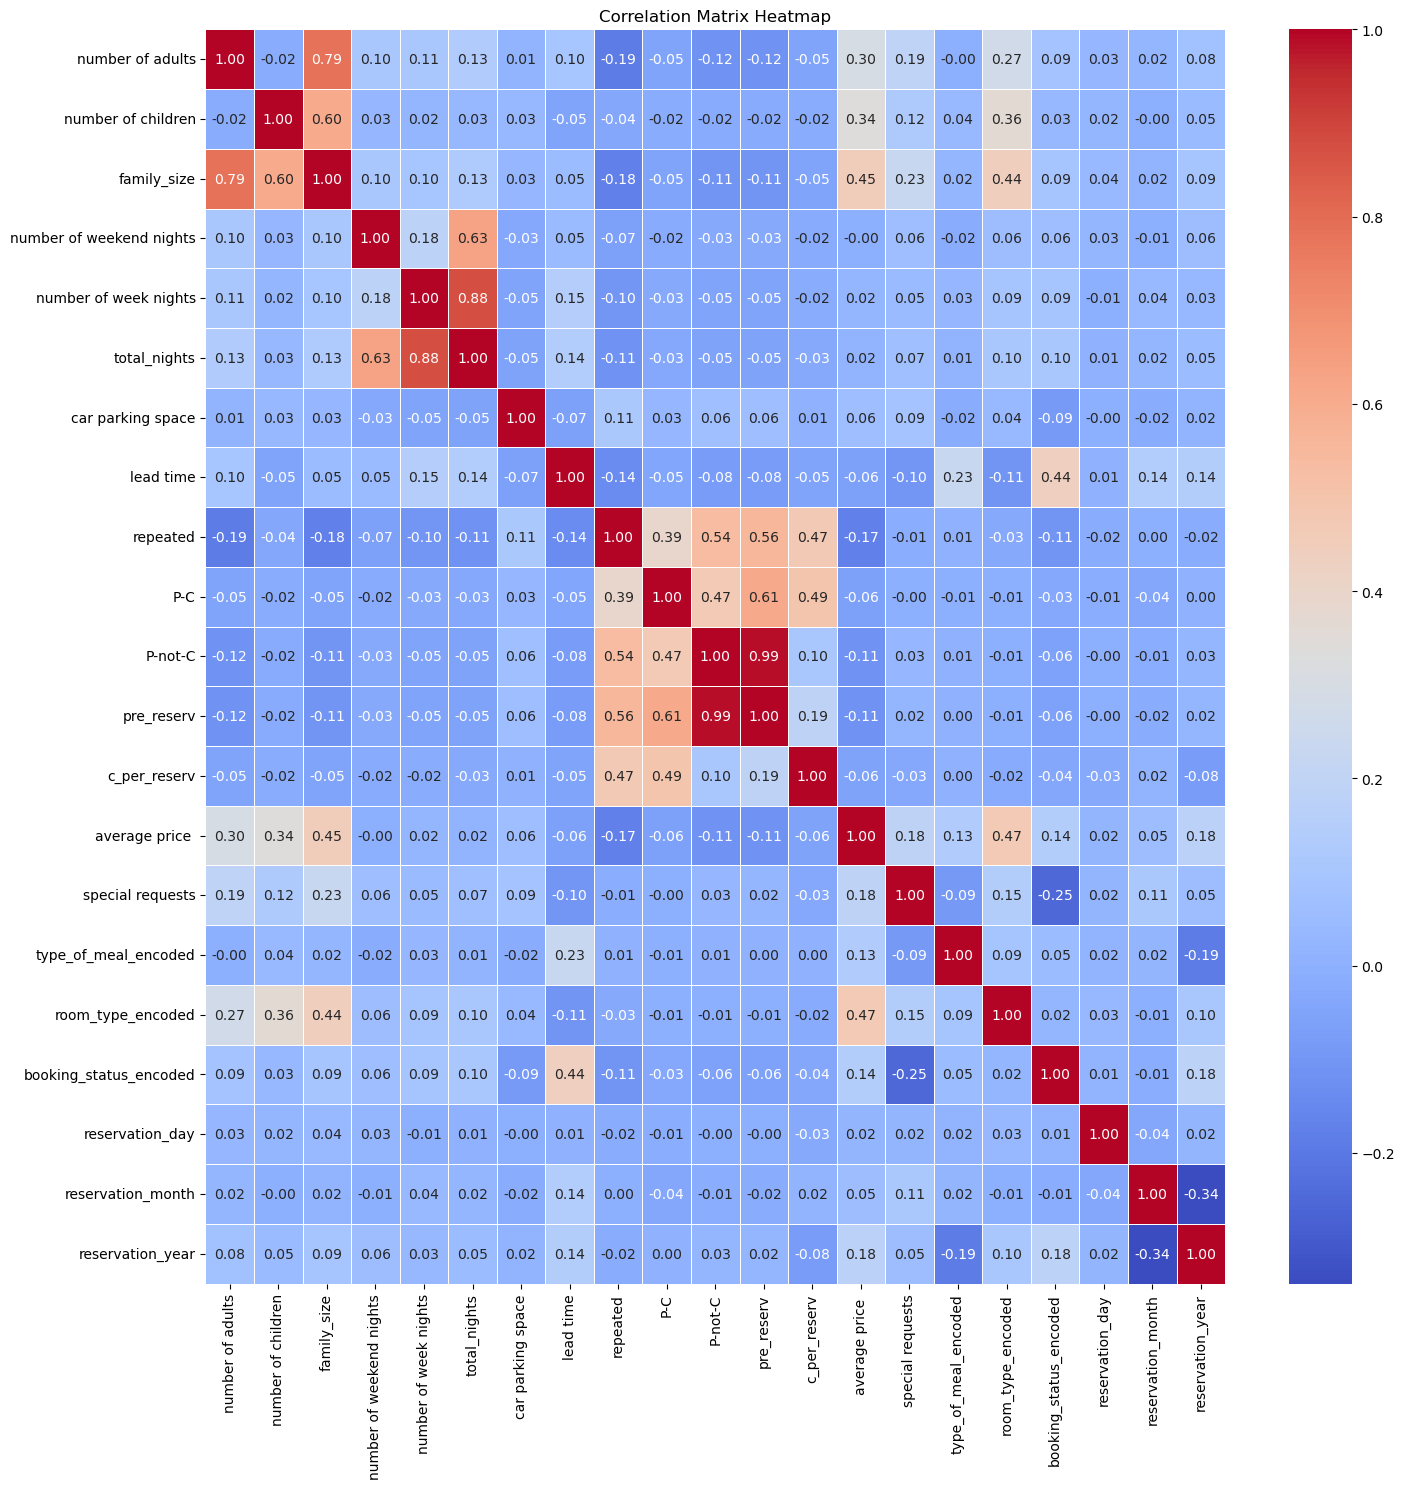

In [192]:
correlation_matrix = df.select_dtypes(['int64', 'float64']).corr()
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot= True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.tight_layout()
plt.show()

Relationships Summary:

- **Family Size & Average Price**: Direct relationship.
- **Family Size & Room Type**: Direct relationship, possibly due to room division based on size.
- **Lead Time & Booking Status**: Direct relationship.
- **Price & Room Type**: Direct relationship.
- **Price & Market Segment**: Direct relationship.

## Relation between family size and room type

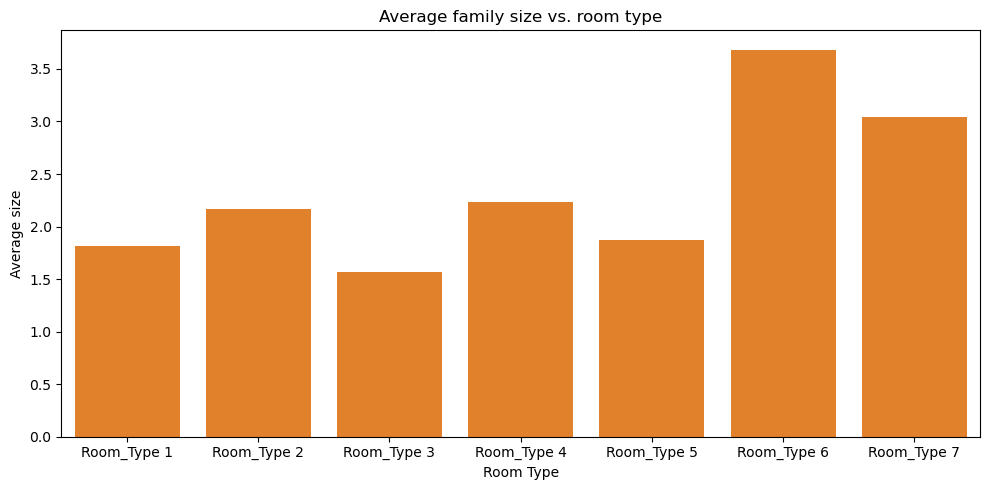

In [193]:
df_grouped = df.groupby('room type')['family_size'].mean().reset_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=df_grouped['room type'], y=df_grouped['family_size'], color='#ff7f0e')
plt.title(f"Average family size vs. room type")
plt.xlabel('Room Type')
plt.ylabel('Average size')
plt.tight_layout()
plt.show()

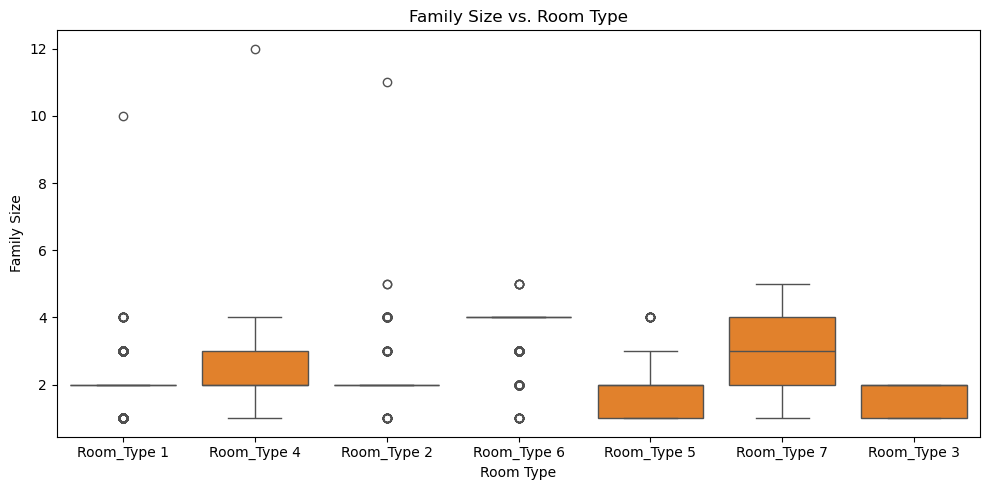

In [194]:
# Box plot for 'Family Size' vs. 'Room Type'
plt.figure(figsize=(10, 5))
sns.boxplot(x=df['room type'], y=df['family_size'], color='#ff7f0e')
plt.title('Family Size vs. Room Type')
plt.xlabel("Room Type")
plt.ylabel('Family Size')
plt.tight_layout()
plt.show()


**Family Size vs. Room Type Summary:**

- **Type 6** is the best for big families as it has high capacity, while **Type 3** is ideal for small families.
- **Type 1 & 2** are sufficient for exactly 2 people.
- **Type 3 & 5** are suitable for 2 people or less.
- **Type 4** is sufficient for 2 or 3 people.
- **Type 6** is sufficient for exactly 4 people.
- **Type 7** is suitable for 2 or more people.

## Relation between features and average Price

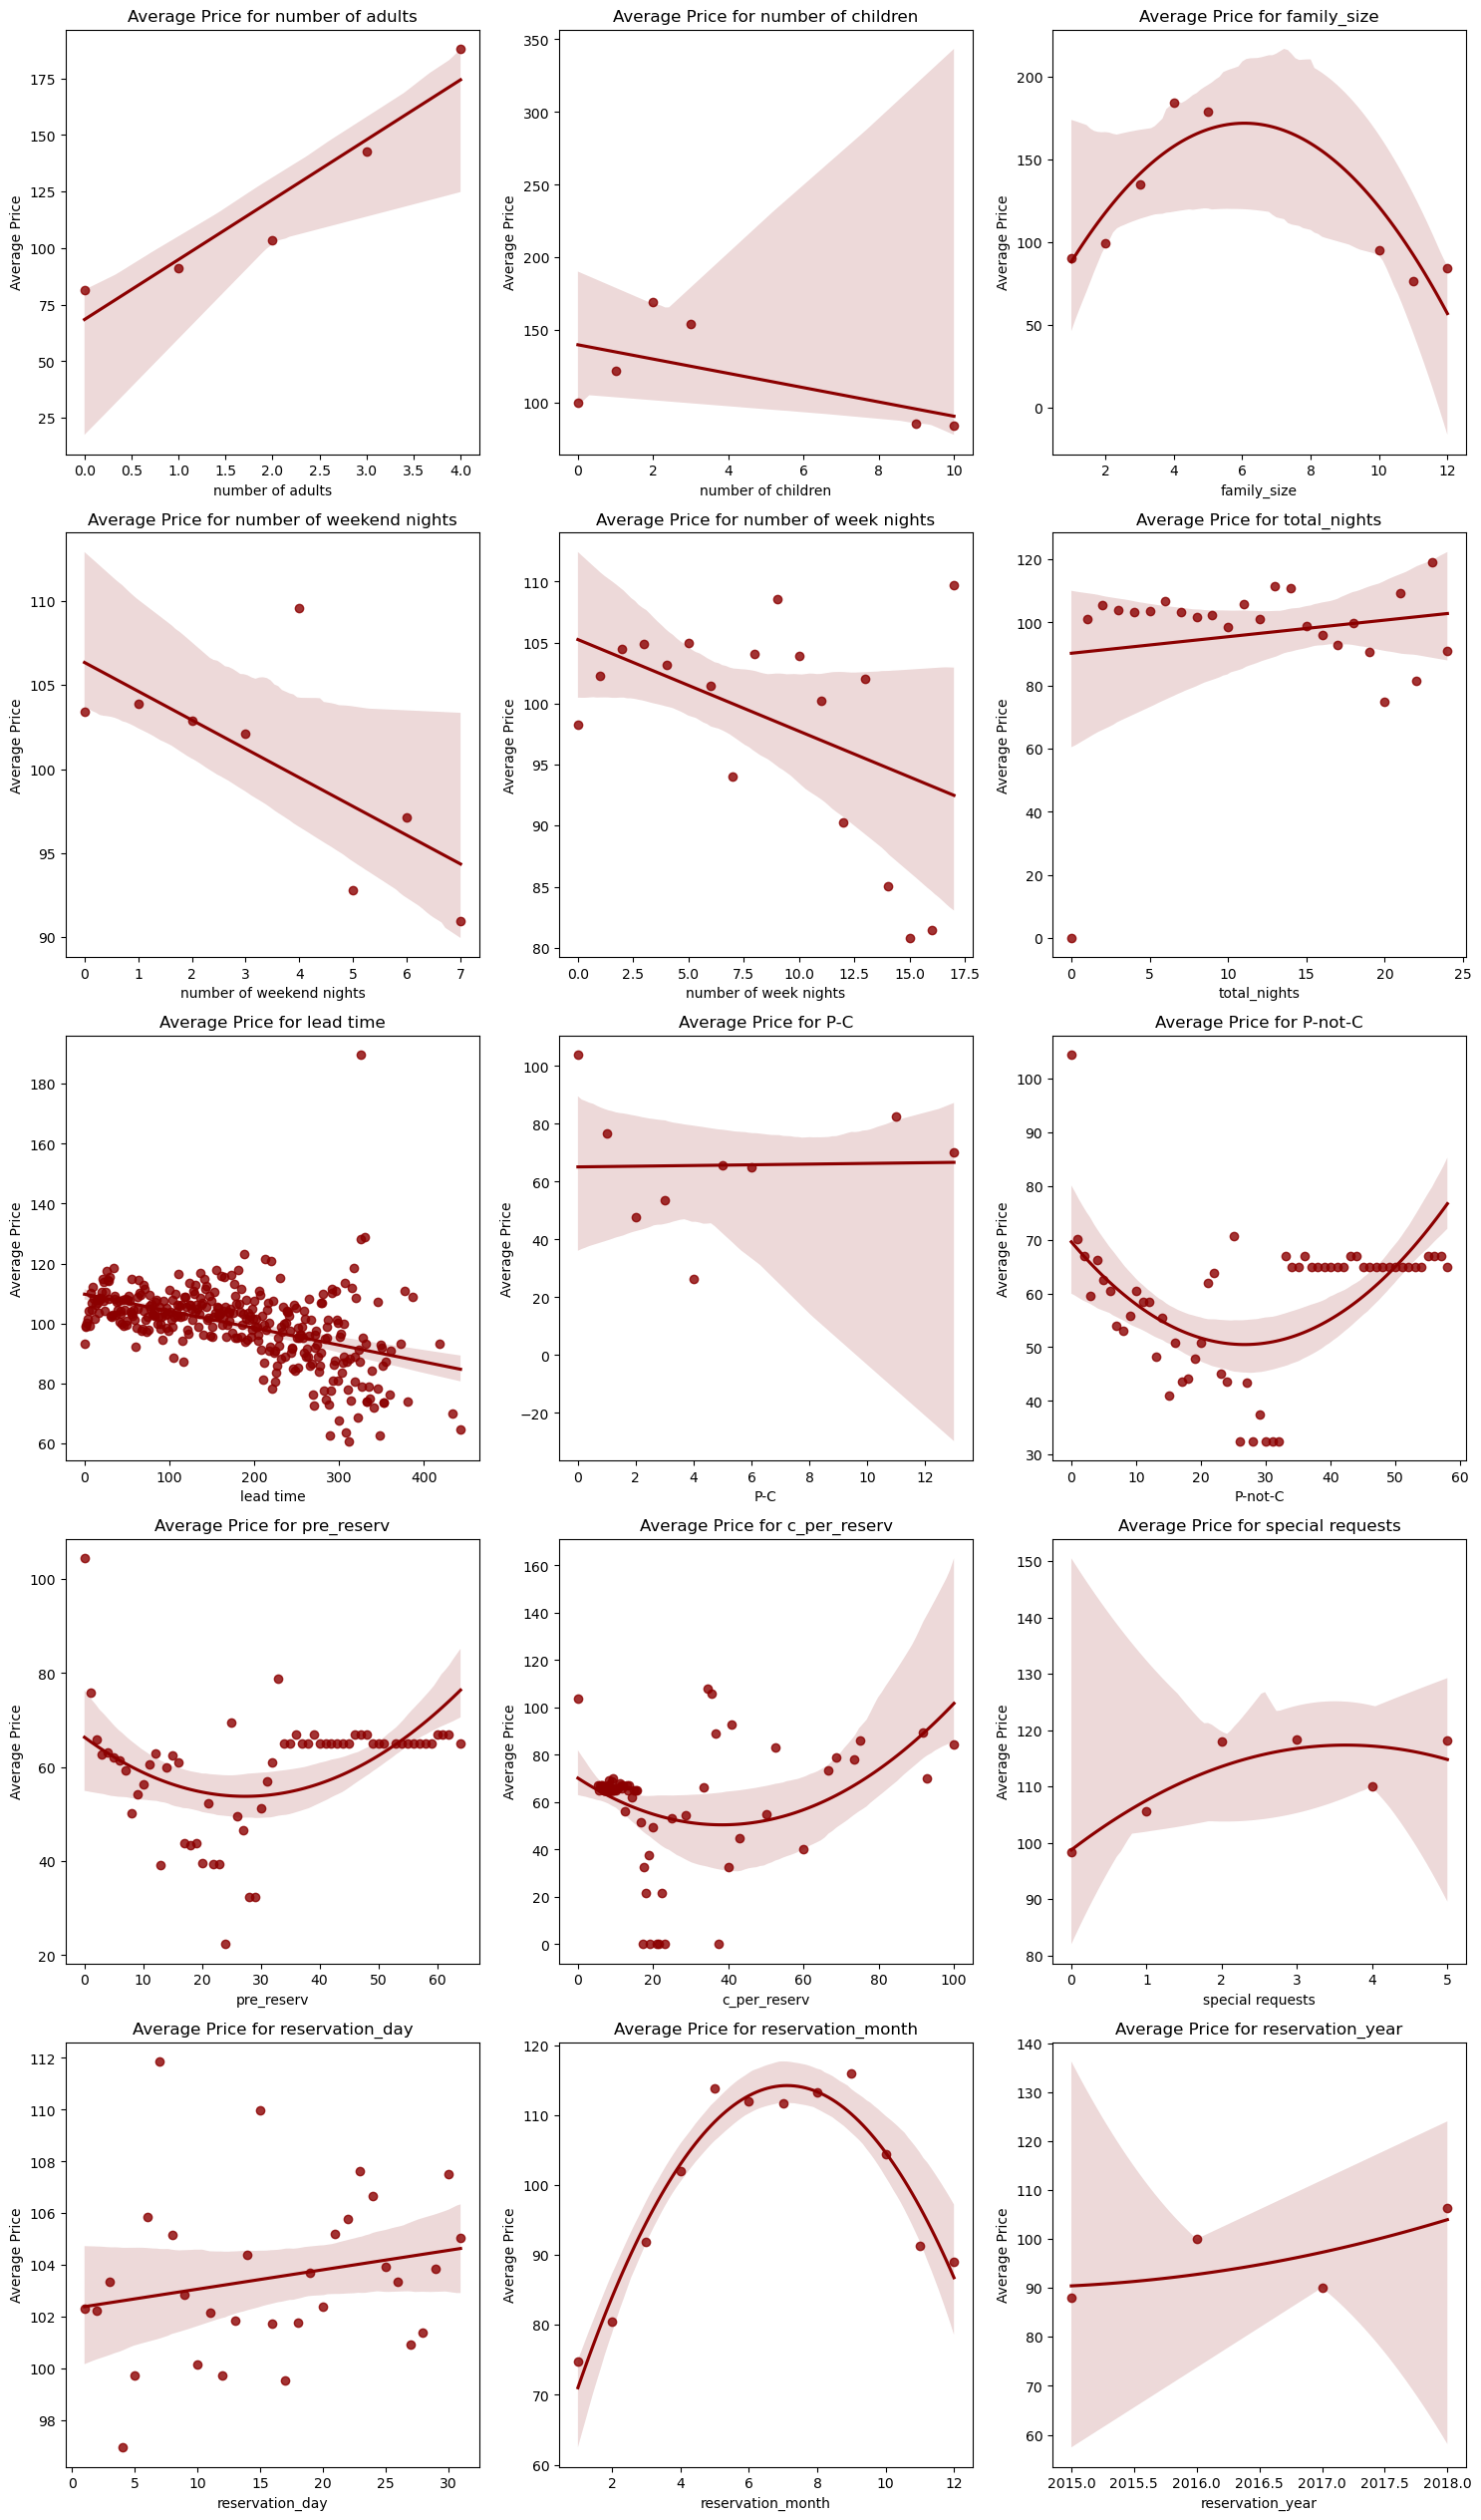

In [195]:
x = 0
rows = math.ceil( (len(numerical_columns)) / 3.0 )
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
axes = axes.flatten()

#numerical_columns
for column in numerical_columns:
    if column == 'average price ':
        continue
    df_grouped = df.groupby(column)['average price '].mean().reset_index()
    
    order = 1
    if column in ['family_size', 'special requests', 'P-not-C', 'pre_reserv', 'c_per_reserv', 'reservation_month', 'reservation_year']:
        order = 2
    sns.regplot(ax= axes[x], x=df_grouped[column], y=df_grouped['average price '], color='darkred', order= order)
    axes[x].set_title(f"Average Price for {column}")
    axes[x].set_xlabel(column)
    axes[x].set_ylabel('Average Price')
    x += 1

for i in range(x, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

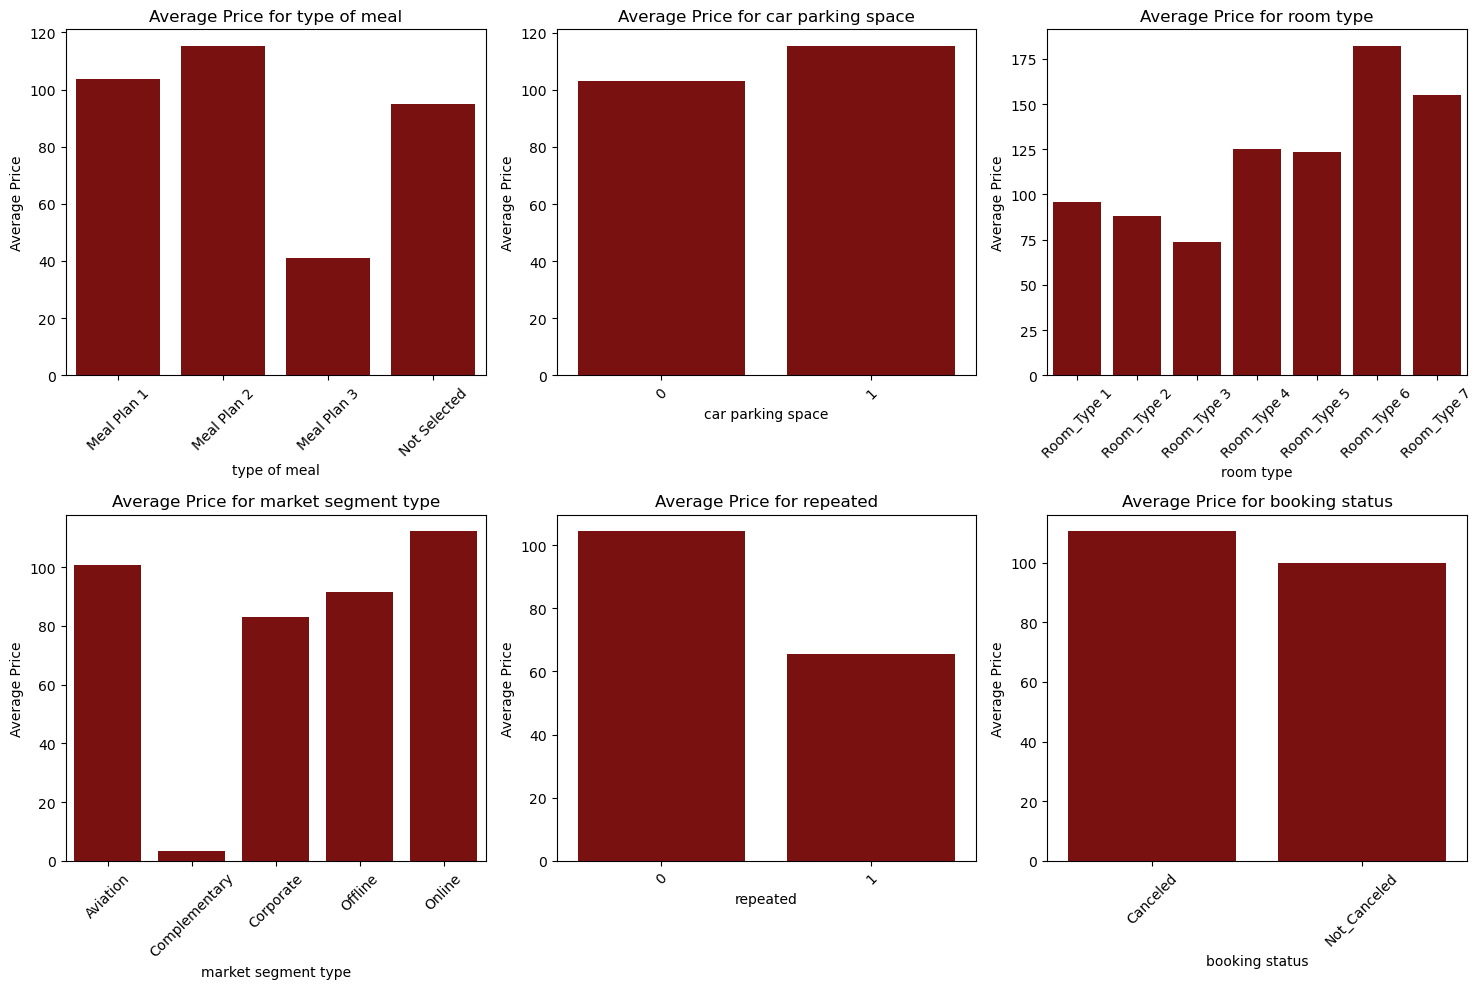

In [196]:
#categorical_columns
x = 0
rows = math.ceil((len(categorical_columns) - 4) / 3.0)
fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

axes = axes.flatten()

for column in categorical_columns:
    if 'encoded' in column:
        continue
    df_grouped = df.groupby(column)['average price '].mean().reset_index()
    
    sns.barplot(ax= axes[x], x=df_grouped[column], y=df_grouped['average price '], color='darkred')
    axes[x].set_title(f"Average Price for {column}")
    axes[x].set_xlabel(column)
    for label in axes[x].get_xticklabels():
        label.set_rotation(45)
    axes[x].set_ylabel('Average Price')
    x += 1

for i in range(x, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**The relationship summary between features and Average Price:**

- **Number of Adults**: Directly related to average price.
- **Number of Children**: Inversely related to average price, possibly due to discounts.
- **Family Size**: Price increases with family size until reaching 7, then it starts decreasing, likely due to discounts.
 
- **Number of Nights**: More nights result in a lower price, possibly due to offers or discounts.
- **Lead Time**: Higher lead time results in a lower price.
- **P-not-C** & **pre_reserv**: Price decreases with reservations below 30, then it starts increasing.
- **c_per_reserv**: Price decreases with rate below 50%, then it starts increasing.
- **Special Requests**: Directly related to average price, but price decreases with 3 or more requests, possibly due to discounts.
- **Reservation Month**: Price increases throughout the first 7 months and then decreases.
- **Reservation Year**: Price increases over the years.

- **Type of Meal**: Meal Plan 2 has the highest price, while Meal Plan 3 has the lowest.
- **Car Parking Space**: Parking space increases the price by around 20%, so most entries don't request it.
- **Room Type**: Room type 6 has the highest price, and type 3 has the lowest.
- **Market Segment Type**: Online reservations have the highest price, while complementary reservations have the lowest.
- **Repeated**: Repeated guests have lower prices, possibly due to discounts.
- **Booking Status**: Canceled bookings are higher in price, which may indicate pricing issues.

## Relation between features and Booking Status

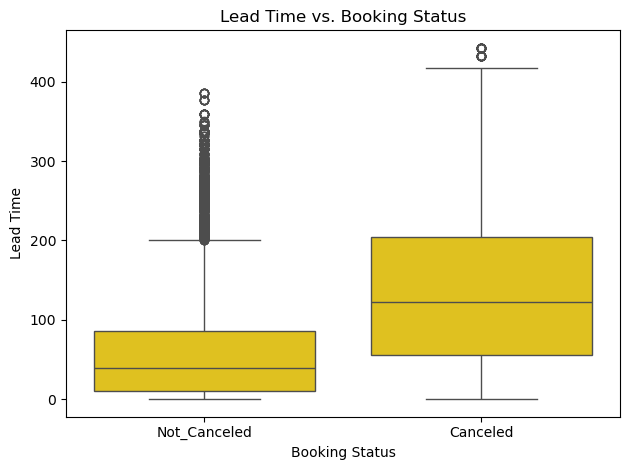

In [197]:
# Box plot for 'lead time' vs. 'booking status'
plt.figure()
sns.boxplot(x=df['booking status'], y=df['lead time'], color='#FFD700')
plt.title('Lead Time vs. Booking Status')
plt.xlabel("Booking Status")
plt.ylabel('Lead Time')
plt.tight_layout()
plt.show()


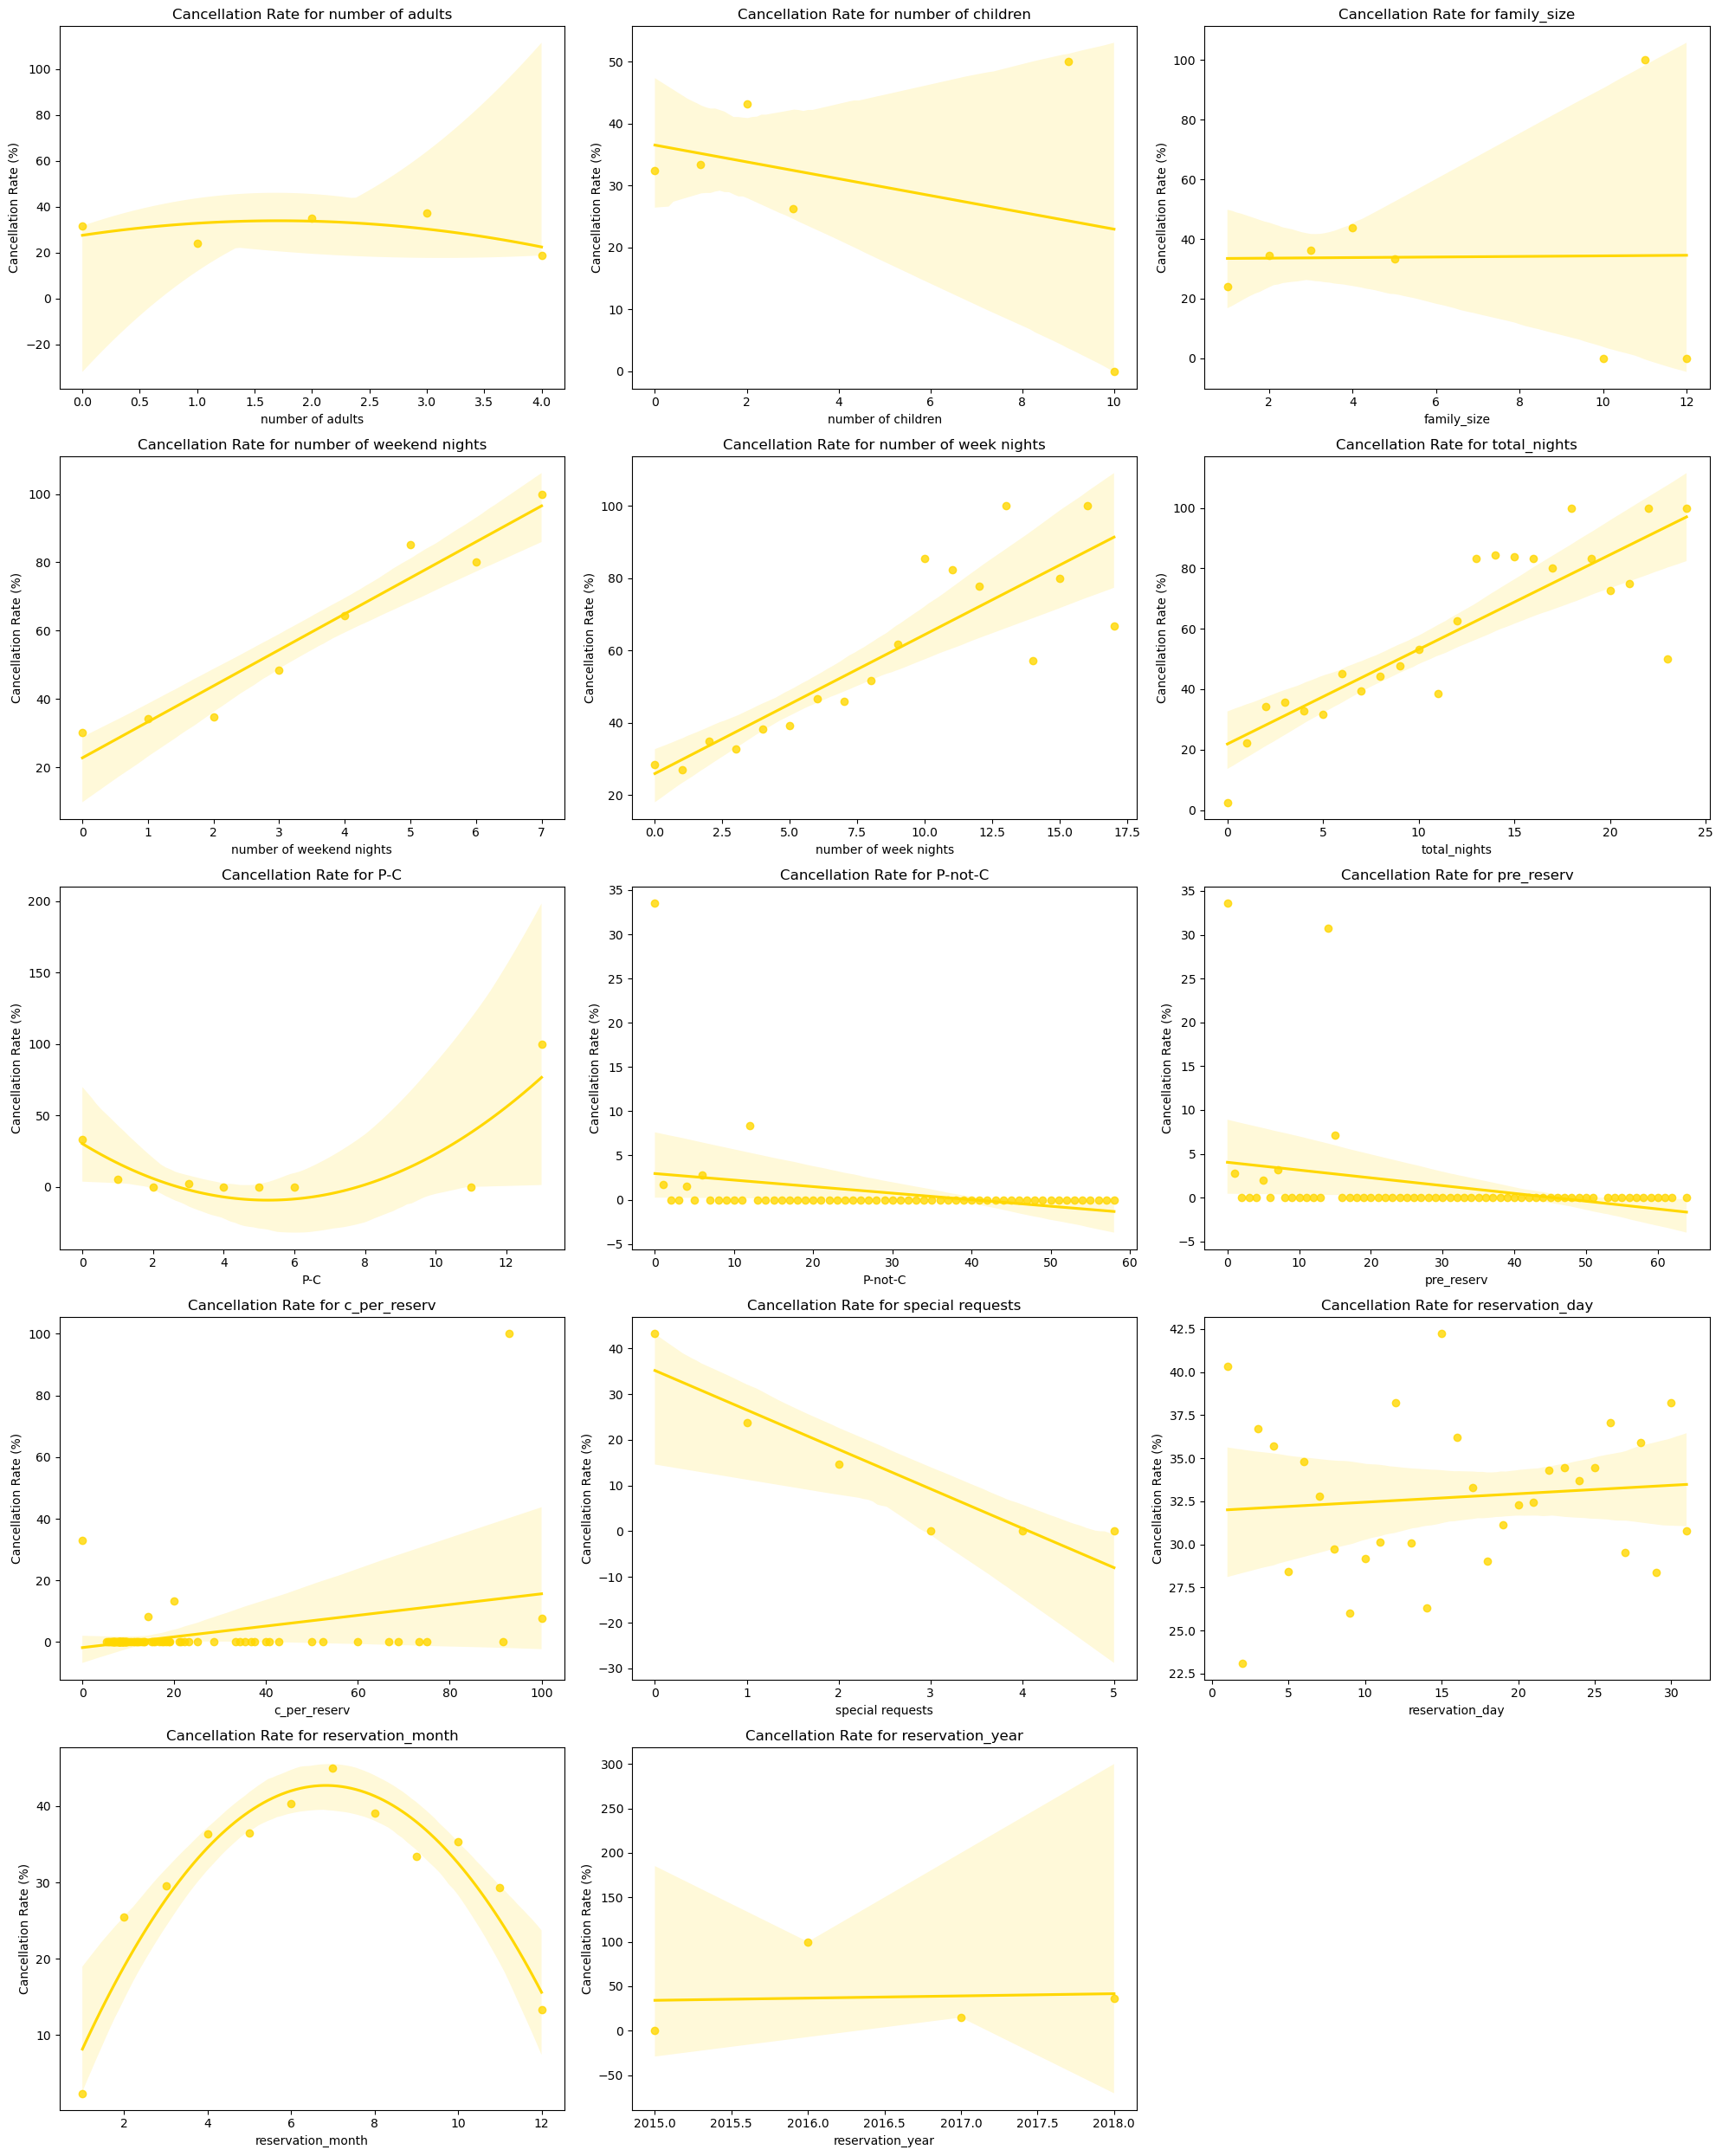

In [198]:
rows = math.ceil((len(numerical_columns) - 2) / 3.0)
fig, axes = plt.subplots(rows, 3, figsize=(20, 5*rows))

# Flatten the axes array for easy indexing
axes = axes.flatten()

index = 0
for column in numerical_columns:
    if column in ['lead time', 'average price ']:
        continue
    df_grouped = df.groupby(column)['booking_status_encoded'].mean().reset_index()
    
    order = 1
    if column in ['number of adults', 'P-C', 'reservation_month']:
        order = 2
     
    sns.regplot(ax=axes[index], x=df_grouped[column], y=df_grouped['booking_status_encoded'] * 100, color='#FFD700', order= order)
    axes[index].set_title(f"Cancellation Rate for {column}")
    axes[index].set_xlabel(column)
    axes[index].set_ylabel('Cancellation Rate (%)')
    index += 1

# Hide any unused subplots
for i in range(index, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

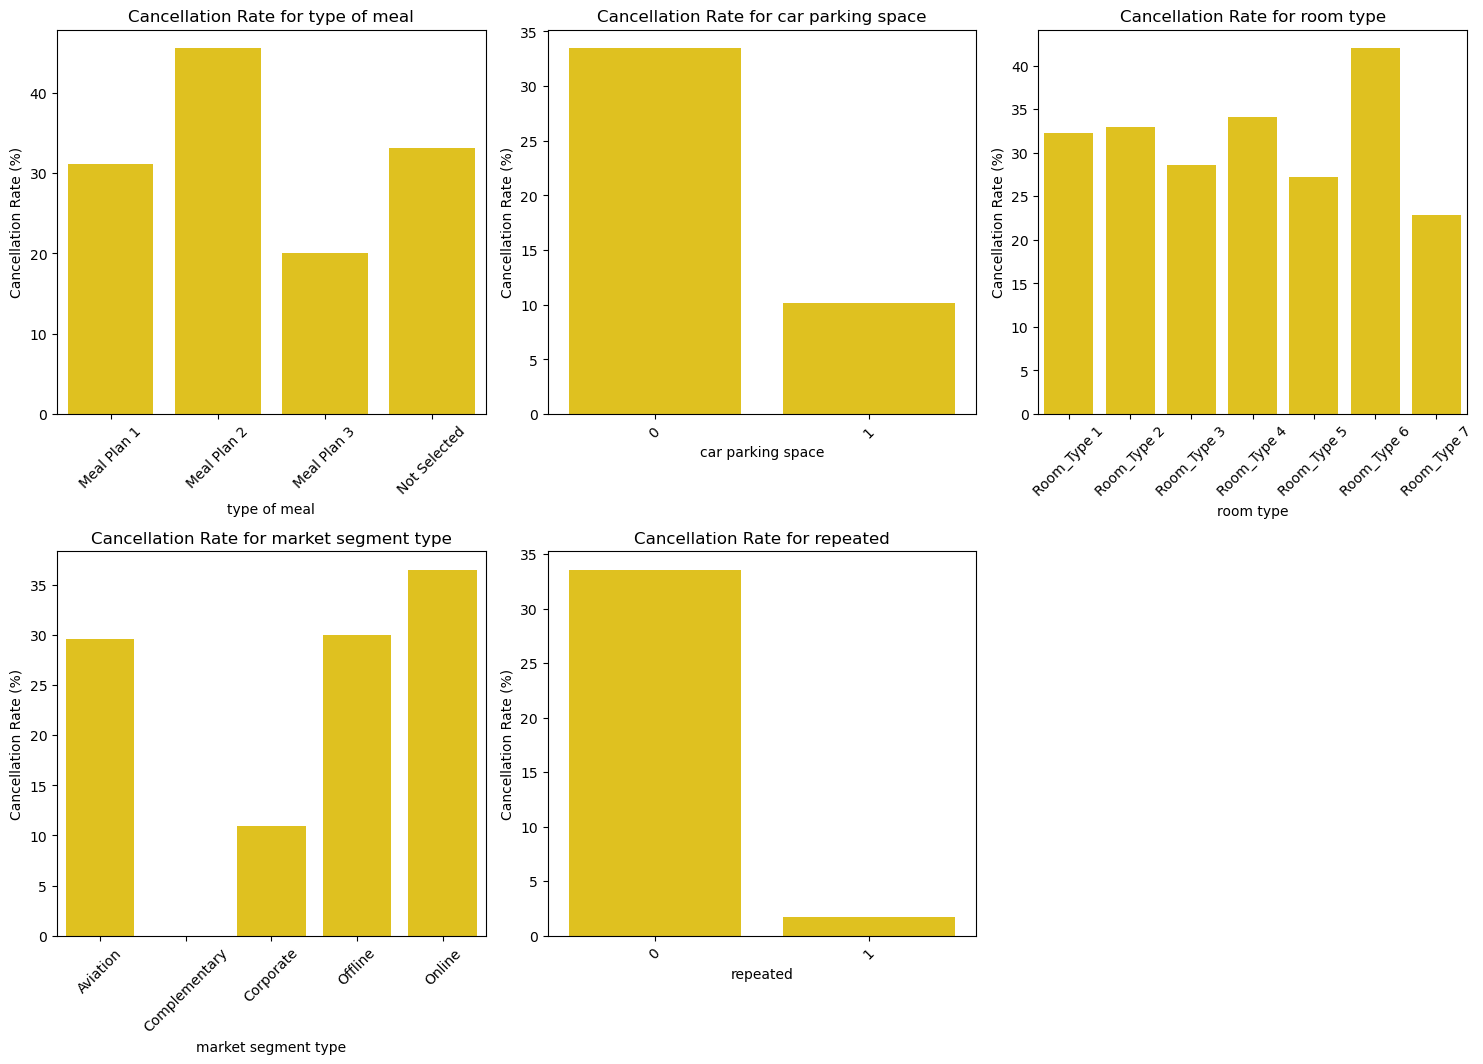

In [199]:
#categorical_columns
x = 0
rows = math.ceil(len(categorical_columns) / 3.0)
fig, axes = plt.subplots(rows, 3, figsize = (15, 5 * rows))

axes = axes.flatten()

for column in categorical_columns:
    if 'encoded' in column or column == "booking status":
        continue
    df_grouped = df.groupby(column)['booking_status_encoded'].mean().reset_index()
    
    sns.barplot(ax = axes[x], x=df_grouped[column], y=df_grouped['booking_status_encoded'] * 100, color='#FFD700')
    axes[x].set_title(f"Cancellation Rate for {column}")
    axes[x].set_xlabel(column)
    for label in axes[x].get_xticklabels():
        label.set_rotation(45)
    axes[x].set_ylabel('Cancellation Rate (%)')
    x += 1

for i in range(x, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**The relationship summary between features and Booking Status:**

- **Lead Time**: Higher lead times are associated with a higher likelihood of cancellation.
- **Number of Children**: Direct relationship with the cancellation rate.
- **Number of Nights**: More nights result in a higher cancellation rate.

- **P-C**: When there are more than 6 previous cancellations, the cancellation rate starts increasing.
- **P-not-C** & **pre_reserv**: Inversely related to the cancellation rate.
- **C_per_resrv**: Direct relationship with the cancellation rate.

- **Special Requests**: More special requests result in a lower cancellation rate.
- **Reservation Month**: Cancellation rate increases during the first 7 months and then decreases, similar to the price trend, implying the effect of price.
- **Type of Meal**: Meal Plan 2 has the highest cancellation rate, while Meal Plan 3 has the lowest.
- **Car Parking Space**: Reservations without a parking space are more likely to cancel.
- **Room Type**: Room type 6 has the highest cancellation rate, while type 7 has the lowest.
- **Market Segment Type**: The online segment has the highest cancellation rate, while the complementary segment rarely cancels.
- **Repeated**: Repeated guests are less likely to cancel, possibly because they enjoy the service.

# Data Preparation

## Dropping Encoded Features 

In [200]:
def drop_encoded_features(df):
    df.drop(['type of meal', 'room type', 'market segment type', 'booking status'], axis=1, inplace=True)

    

drop_encoded_features(df)
categorical_columns = [x for x in categorical_columns if x in df.columns]

## Scaling

In [201]:
# Scaling numerical columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[numerical_columns])
scaled_df = pd.DataFrame(scaled_data, columns=numerical_columns)

#join scaled numberical columns with categorical columns
df = scaled_df.join(df[categorical_columns])

In [202]:
df.describe()

,number of adults,number of children,family_size,number of weekend nights,number of week nights,total_nights,lead time,P-C,P-not-C,pre_reserv,...,special requests,reservation_day,reservation_month,reservation_year,car parking space,repeated,type_of_meal_encoded,room_type_encoded,market_segment_type_encoded,booking_status_encoded
count,3.628500e+04,3.628500e+04,3.628500e+04,36285.000000,3.628500e+04,3.628500e+04,3.628500e+04,3.628500e+04,3.628500e+04,3.628500e+04,...,3.628500e+04,3.628500e+04,3.628500e+04,3.628500e+04,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000
mean,-1.406007e-16,-3.348568e-17,-4.503923e-17,0.000000,-1.131855e-16,-8.028731e-17,1.684075e-17,-9.595313e-18,2.996088e-17,-1.762404e-17,...,1.684075e-17,-6.227162e-17,4.797657e-17,-1.418031e-14,0.030977,0.025630,0.949952,1.708860,3.552487,0.327656
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,...,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,0.173258,0.158032,0.480209,1.399801,0.681489,0.469365
min,-3.555935e+00,-2.616355e-01,-1.461055e+00,-0.931212,-1.562521e+00,-1.688319e+00,-9.918806e-01,-6.338450e-02,-8.744431e-02,-9.045419e-02,...,-7.882118e-01,-1.666434e+00,-2.093968e+00,-7.339943e+00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,2.990725e-01,-2.616355e-01,7.657424e-02,-0.931212,-8.537670e-01,-5.684825e-01,-7.940627e-01,-6.338450e-02,-8.744431e-02,-9.045419e-02,...,-7.882118e-01,-8.657116e-01,-7.902961e-01,4.677211e-01,0.000000,0.000000,1.000000,1.000000,3.000000,0.000000
50%,2.990725e-01,-2.616355e-01,7.657424e-02,0.217450,-1.450128e-01,-8.564272e-03,-3.286088e-01,-6.338450e-02,-8.744431e-02,-9.045419e-02,...,-7.882118e-01,4.939988e-02,1.874578e-01,4.677211e-01,0.000000,0.000000,1.000000,1.000000,4.000000,0.000000
75%,2.990725e-01,-2.616355e-01,7.657424e-02,1.366111,5.637413e-01,5.513540e-01,4.742993e-01,-6.338450e-02,-8.744431e-02,-9.045419e-02,...,4.836460e-01,8.501224e-01,8.392938e-01,4.677211e-01,0.000000,0.000000,1.000000,1.000000,4.000000,1.000000
max,4.154081e+00,2.457081e+01,1.545287e+01,7.109419,1.048630e+01,1.174972e+01,4.163022e+00,3.523625e+01,3.298159e+01,3.266943e+01,...,5.571077e+00,1.765234e+00,1.491130e+00,4.677211e-01,1.000000,1.000000,3.000000,7.000000,4.000000,1.000000


## Handling Outliers

### Percentage of Outliers 

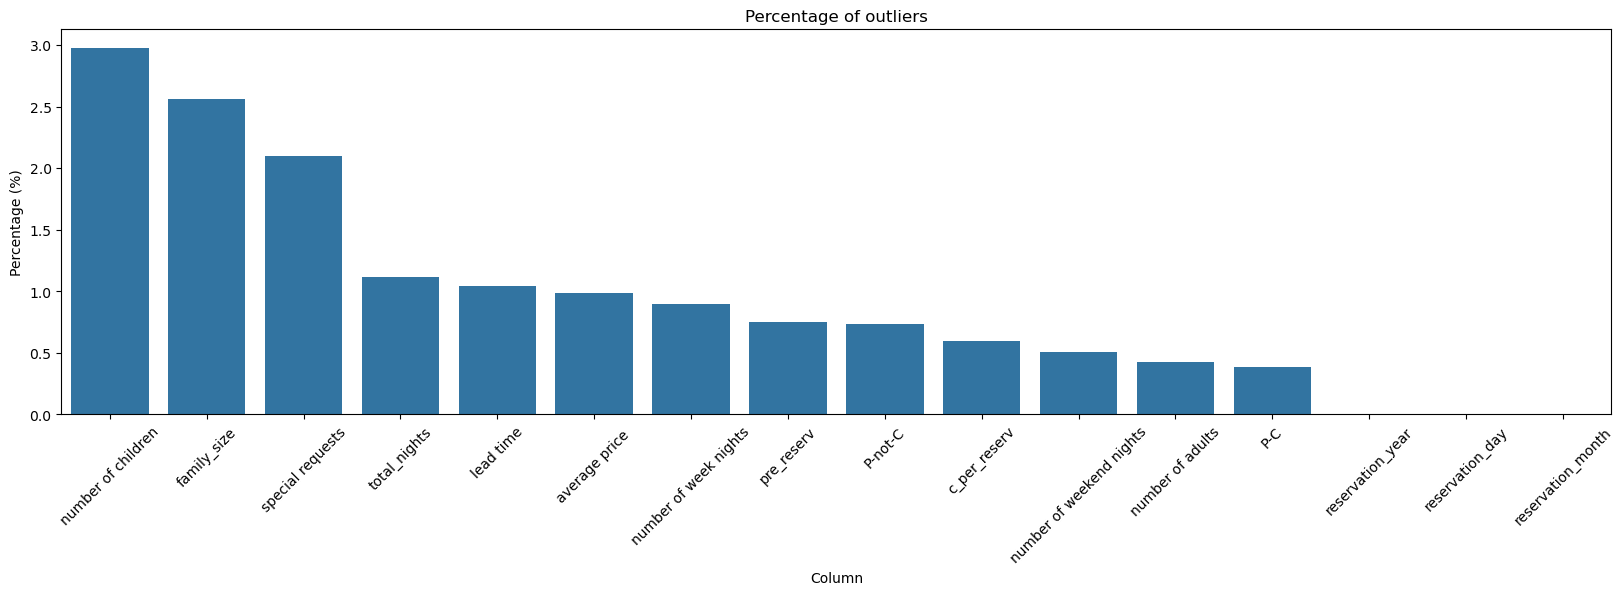

In [203]:
outliers = {}

#abs(z-score) > 3 -> Outlier
for column in numerical_columns:
    outlier_number = df[abs(df[column]) > 3].shape[0]
    percent = (outlier_number /  df.shape[0]) * 100
    outliers[column] = percent

outliers = dict(sorted(outliers.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(20, 5))
sns.barplot(x= list(outliers.keys()), y = list(outliers.values()))
plt.title("Percentage of outliers")
plt.xlabel("Column")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45)
plt.show()

In [204]:
# outliers count based on z-score
outliers_count = df[(df[numerical_columns].abs() > 3).any(axis=1)].shape[0]
print("Number of outliers:", outliers_count)

outlier_percentage = (outliers_count / df.shape[0]) * 100
print(f"\nPercentage of outliers: {outlier_percentage:.2f}%")


Number of outliers: 3127

Percentage of outliers: 8.62%


**High Number of outliers wich can't be dropped**

### Min/Max Replacing

In [205]:
# Identify outliers (z-score > 3 or < -3)
outliers = (scaled_df.abs() > 3)

# Replace outliers with min/max
for column in numerical_columns:
    min_value = df.loc[~outliers[column], column].min()
    max_value = df.loc[~outliers[column], column].max()

    # Replace values greater than 3 with max value
    df.loc[outliers[column], column] = max_value
    
    # Replace values less than -3 with min value
    df.loc[outliers[column], column] = min_value


df.describe()

,number of adults,number of children,family_size,number of weekend nights,number of week nights,total_nights,lead time,P-C,P-not-C,pre_reserv,...,special requests,reservation_day,reservation_month,reservation_year,car parking space,repeated,type_of_meal_encoded,room_type_encoded,market_segment_type_encoded,booking_status_encoded
count,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,...,36285.000000,3.628500e+04,3.628500e+04,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000,36285.000000
mean,0.004834,-0.150630,-0.119756,-0.025737,-0.056724,-0.072835,-0.046193,-0.048567,-0.067771,-0.069449,...,-0.083423,-6.227162e-17,4.797657e-17,0.000215,0.030977,0.025630,0.949952,1.708860,3.552487,0.327656
std,0.977386,0.513165,0.874915,0.955705,0.889477,0.853703,0.939574,0.200039,0.186753,0.188717,...,0.888138,1.000014e+00,1.000014e+00,0.999087,0.173258,0.158032,0.480209,1.399801,0.681489,0.469365
min,-1.628431,-0.261636,-1.461055,-0.931212,-1.562521,-1.688319,-0.991881,-0.063385,-0.087444,-0.090454,...,-0.788212,-1.666434e+00,-2.093968e+00,-2.134834,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,0.299073,-0.261636,0.076574,-0.931212,-0.853767,-0.568483,-0.805699,-0.063385,-0.087444,-0.090454,...,-0.788212,-8.657116e-01,-7.902961e-01,0.467721,0.000000,0.000000,1.000000,1.000000,3.000000,0.000000
50%,0.299073,-0.261636,0.076574,0.217450,-0.145013,-0.008564,-0.340245,-0.063385,-0.087444,-0.090454,...,-0.788212,4.939988e-02,1.874578e-01,0.467721,0.000000,0.000000,1.000000,1.000000,4.000000,0.000000
75%,0.299073,-0.261636,0.076574,1.366111,0.563741,0.551354,0.427754,-0.063385,-0.087444,-0.090454,...,0.483646,8.501224e-01,8.392938e-01,0.467721,0.000000,0.000000,1.000000,1.000000,4.000000,1.000000
max,2.226577,2.221609,1.614204,2.514773,2.690004,2.791027,2.976114,2.651972,2.763335,2.980784,...,1.755504,1.765234e+00,1.491130e+00,0.467721,1.000000,1.000000,3.000000,7.000000,4.000000,1.000000


## Split the Data

In [206]:
#split data_train into x, y (target)
X = df.drop("booking_status_encoded", axis=1) 
y = df["booking_status_encoded"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

#best_acc dictionary to map all models
best_acc = {}

## SMOTE Oversampling

**SMOTE Oversampling handles the imbalanced data** (The number of non-cancellations is bigger than the number of cancellations)

In [207]:
X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

Balance = y_train.value_counts()
print("Balance:", Balance)

Balance: booking_status_encoded
1    19541
0    19541
Name: count, dtype: int64


# Model Training

## KNN Model

### Model Training

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters for KNN: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Train Accuracy for KNN: 99.37%
Test Accuracy for KNN: 83.44%
Confusion Matrix for KNN:


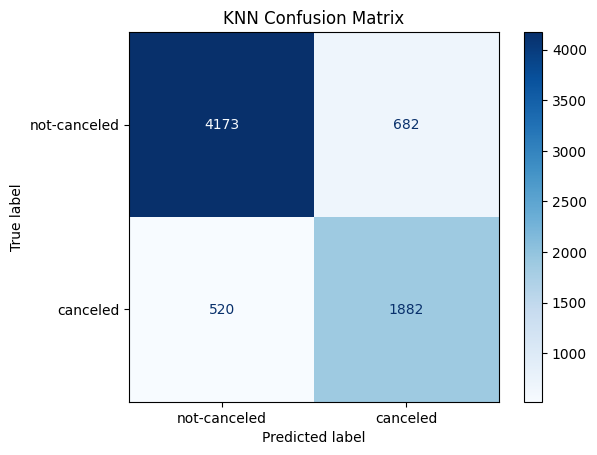

Classification Report for KNN:
              precision    recall  f1-score   support

not-canceled       0.89      0.86      0.87      4855
    canceled       0.73      0.78      0.76      2402

    accuracy                           0.83      7257
   macro avg       0.81      0.82      0.82      7257
weighted avg       0.84      0.83      0.84      7257



In [34]:
# Define KNN model and parameter grid
knn_model = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [3, 7, 11, 15, 19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

# GridSearchCV
knn_grid_search = GridSearchCV(knn_model, knn_param_grid, cv=5, scoring='accuracy', verbose=1, return_train_score=True)
knn_grid_search.fit(X_train, y_train)

# Best estimator and parameters
knn_best_model = knn_grid_search.best_estimator_
knn_best_params = knn_grid_search.best_params_
print(f"Best Parameters for KNN: {knn_best_params}")

# Train accuracy
knn_y_pred_train = knn_best_model.predict(X_train)
knn_accuracy_train = accuracy_score(y_train, knn_y_pred_train)
print(f"Train Accuracy for KNN: {knn_accuracy_train * 100:.2f}%")

# Test accuracy
knn_y_pred_test = knn_best_model.predict(X_test)
knn_accuracy_test = accuracy_score(y_test, knn_y_pred_test)
print(f"Test Accuracy for KNN: {knn_accuracy_test * 100:.2f}%")

# Confusion matrix
knn_conf_matrix = confusion_matrix(y_test, knn_y_pred_test)
print("Confusion Matrix for KNN:")
ConfusionMatrixDisplay(knn_conf_matrix, display_labels=['not-canceled', 'canceled']).plot(cmap='Blues')
plt.title('KNN Confusion Matrix')
plt.show()

# Classification report
print("Classification Report for KNN:")
print(classification_report(y_test, knn_y_pred_test, target_names=['not-canceled', 'canceled']))

### Elbow Method

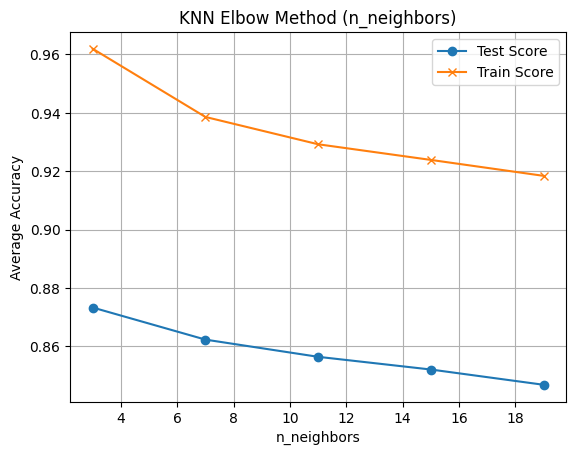

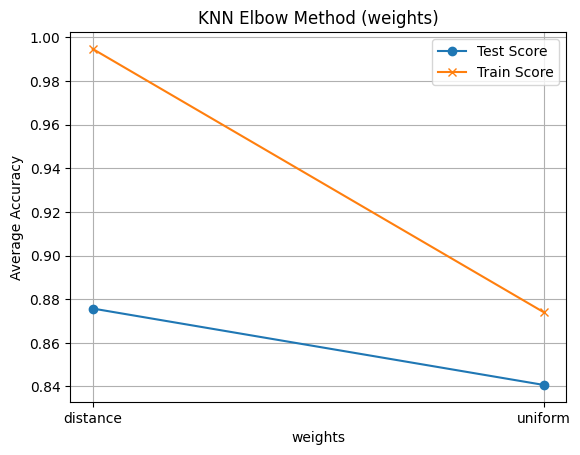

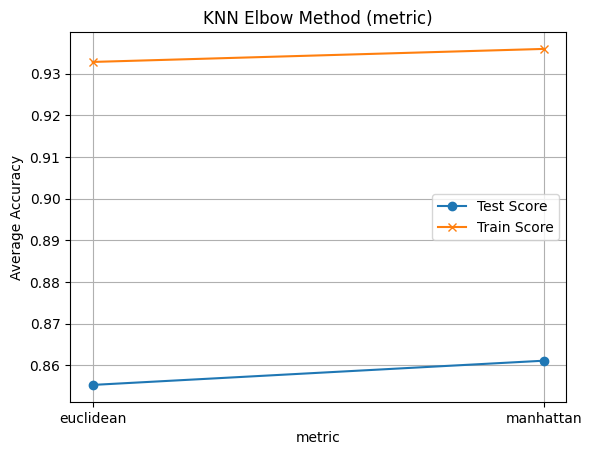

In [35]:
# Elbow method plot for KNN
knn_results = pd.DataFrame(knn_grid_search.cv_results_)
for param in knn_param_grid:
    avg_test_score = knn_results.groupby(f'param_{param}')['mean_test_score'].mean().reset_index()
    avg_train_score = knn_results.groupby(f'param_{param}')['mean_train_score'].mean().reset_index()
    plt.plot(avg_test_score[f'param_{param}'], avg_test_score['mean_test_score'], marker='o', label='Test Score')
    plt.plot(avg_train_score[f'param_{param}'], avg_train_score['mean_train_score'], marker='x', label='Train Score')
    plt.xlabel(param)
    plt.ylabel('Average Accuracy')
    plt.title(f'KNN Elbow Method ({param})')
    plt.legend()
    plt.grid(True)
    plt.show()

### Feature Importance

Feature Importance (Permutation) for KNN:


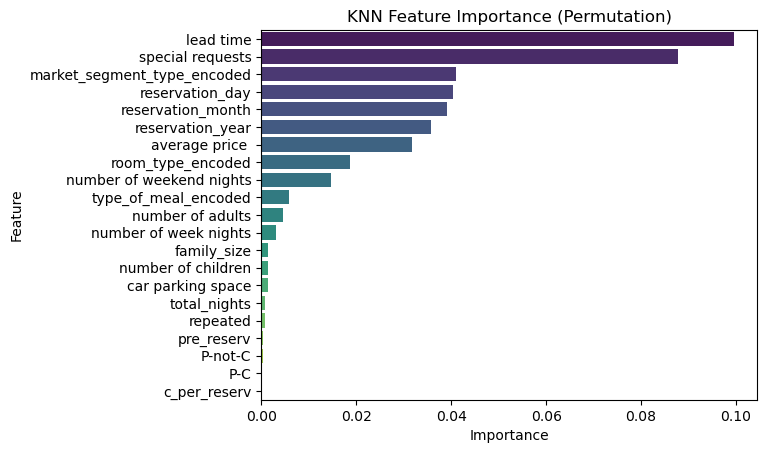

In [221]:
# Permutation importance for KNN
knn_result = permutation_importance(knn_best_model, X_test, y_test, random_state=42)
knn_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(knn_result.importances_mean)
}).sort_values(by='Importance', ascending=False)
print("Feature Importance (Permutation) for KNN:")
ax = sns.barplot(x='Importance', y='Feature', hue='Feature', data=knn_feature_importance_df, palette='viridis')
plt.title('KNN Feature Importance (Permutation)')
plt.show()

best_acc['KNN'] = knn_accuracy_test * 100

## SVM Model

### Model Training

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Train Accuracy for SVM: 84.76%
Test Accuracy for SVM: 82.49%
Confusion Matrix for SVM:


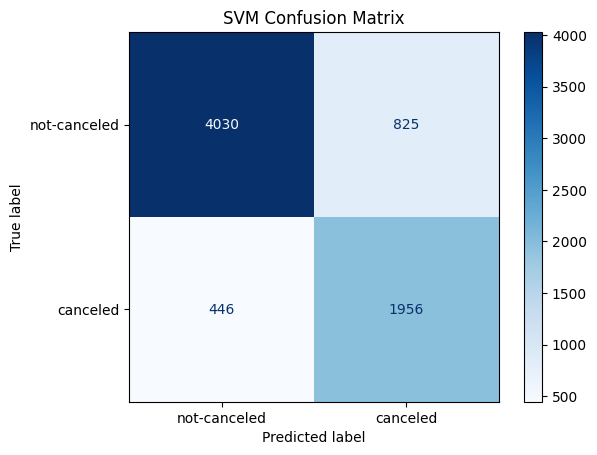

Classification Report for SVM:
              precision    recall  f1-score   support

not-canceled       0.90      0.83      0.86      4855
    canceled       0.70      0.81      0.75      2402

    accuracy                           0.82      7257
   macro avg       0.80      0.82      0.81      7257
weighted avg       0.84      0.82      0.83      7257



In [37]:
# Define SVM model and parameter grid
svm_model = SVC()
svm_param_grid = {
    'C': [1, 4, 7, 10],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

# GridSearchCV
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='accuracy', verbose=1, return_train_score=True)
svm_grid_search.fit(X_train, y_train)

# Best estimator and parameters
svm_best_model = svm_grid_search.best_estimator_
svm_best_params = svm_grid_search.best_params_
print(f"Best Parameters for SVM: {svm_best_params}")

# Train accuracy
svm_y_pred_train = svm_best_model.predict(X_train)
svm_accuracy_train = accuracy_score(y_train, svm_y_pred_train)
print(f"Train Accuracy for SVM: {svm_accuracy_train * 100:.2f}%")

# Test accuracy
svm_y_pred_test = svm_best_model.predict(X_test)
svm_accuracy_test = accuracy_score(y_test, svm_y_pred_test)
print(f"Test Accuracy for SVM: {svm_accuracy_test * 100:.2f}%")

# Confusion matrix
svm_conf_matrix = confusion_matrix(y_test, svm_y_pred_test)
print("Confusion Matrix for SVM:")
ConfusionMatrixDisplay(svm_conf_matrix, display_labels=['not-canceled', 'canceled']).plot(cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.show()

# Classification report
print("Classification Report for SVM:")
print(classification_report(y_test, svm_y_pred_test, target_names=['not-canceled', 'canceled']))


### Elbow Method

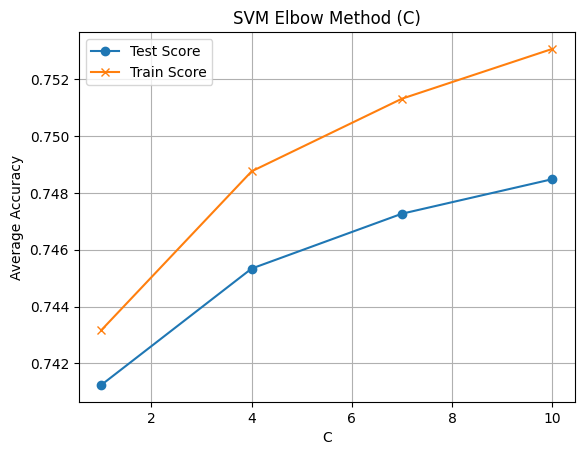

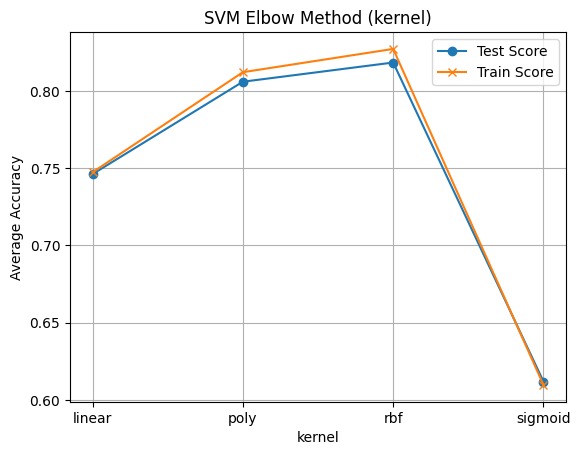

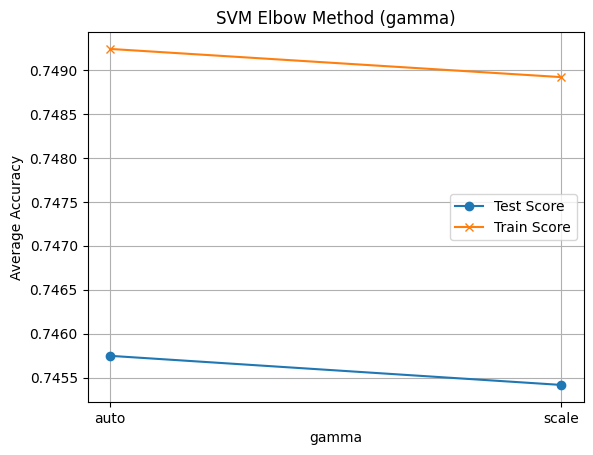

In [38]:
# Elbow method plot for SVM
svm_results = pd.DataFrame(svm_grid_search.cv_results_)
for param in svm_param_grid:
    avg_test_score = svm_results.groupby(f'param_{param}')['mean_test_score'].mean().reset_index()
    avg_train_score = svm_results.groupby(f'param_{param}')['mean_train_score'].mean().reset_index()
    plt.plot(avg_test_score[f'param_{param}'], avg_test_score['mean_test_score'], marker='o', label='Test Score')
    plt.plot(avg_train_score[f'param_{param}'], avg_train_score['mean_train_score'], marker='x', label='Train Score')
    plt.xlabel(param)
    plt.ylabel('Average Accuracy')
    plt.title(f'SVM Elbow Method ({param})')
    plt.legend()
    plt.grid(True)
    plt.show()

### Feature Importance

Feature Importance (Permutation) for SVM:


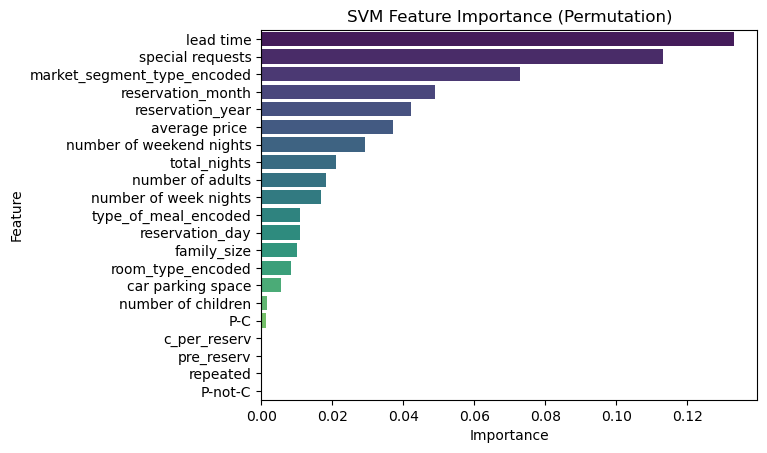

In [223]:
# Permutation importance for SVM
svm_result = permutation_importance(svm_best_model, X_test, y_test, random_state=42)
svm_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': abs(svm_result.importances_mean)
}).sort_values(by='Importance', ascending=False)
print("Feature Importance (Permutation) for SVM:")
ax = sns.barplot(x='Importance', y='Feature', hue='Feature', data=svm_feature_importance_df, palette='viridis')
plt.title('SVM Feature Importance (Permutation)')
plt.show()

best_acc['SVM'] = svm_accuracy_test * 100

## Random Forest Model

### Model Training

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Train Accuracy for Random Forest: 99.50%
Test Accuracy for Random Forest: 88.55%
Confusion Matrix for Random Forest:


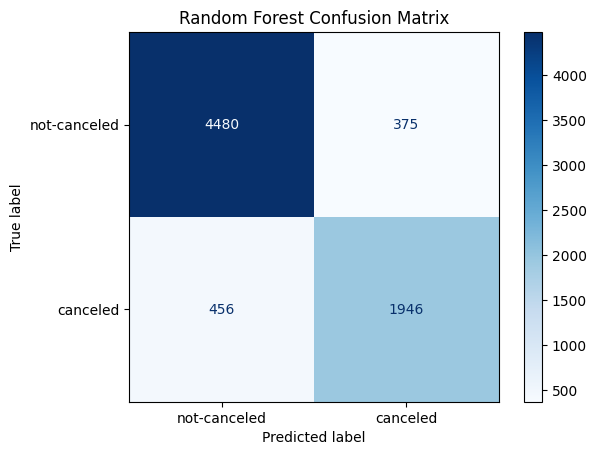

Classification Report for Random Forest:
              precision    recall  f1-score   support

not-canceled       0.91      0.92      0.92      4855
    canceled       0.84      0.81      0.82      2402

    accuracy                           0.89      7257
   macro avg       0.87      0.87      0.87      7257
weighted avg       0.88      0.89      0.88      7257



In [40]:
# Define Random Forest model and parameter grid
rf_model = RandomForestClassifier(random_state=42)
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# GridSearchCV
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='accuracy', verbose=1, return_train_score=True)
rf_grid_search.fit(X_train, y_train)

# Best estimator and parameters
rf_best_model = rf_grid_search.best_estimator_
rf_best_params = rf_grid_search.best_params_
print(f"Best Parameters for Random Forest: {rf_best_params}")

# Train accuracy
rf_y_pred_train = rf_best_model.predict(X_train)
rf_accuracy_train = accuracy_score(y_train, rf_y_pred_train)
print(f"Train Accuracy for Random Forest: {rf_accuracy_train * 100:.2f}%")

# Test accuracy
rf_y_pred_test = rf_best_model.predict(X_test)
rf_accuracy_test = accuracy_score(y_test, rf_y_pred_test)
print(f"Test Accuracy for Random Forest: {rf_accuracy_test * 100:.2f}%")

# Confusion matrix
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred_test)
print("Confusion Matrix for Random Forest:")
ConfusionMatrixDisplay(rf_conf_matrix, display_labels=['not-canceled', 'canceled']).plot(cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.show()

# Classification report
print("Classification Report for Random Forest:")
print(classification_report(y_test, rf_y_pred_test, target_names=['not-canceled', 'canceled']))


### Elbow Method

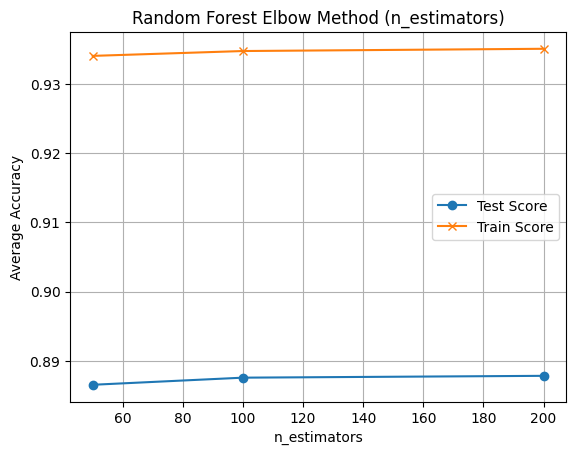

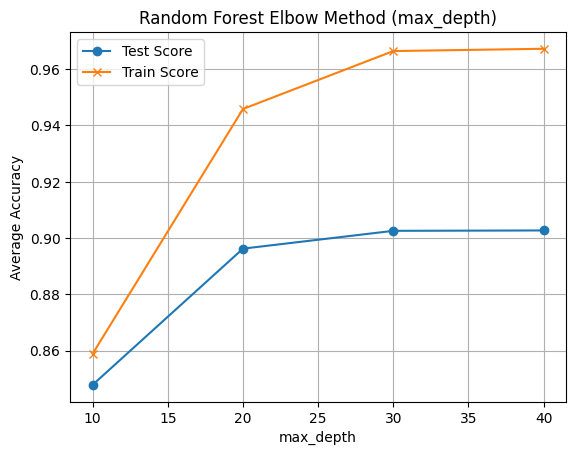

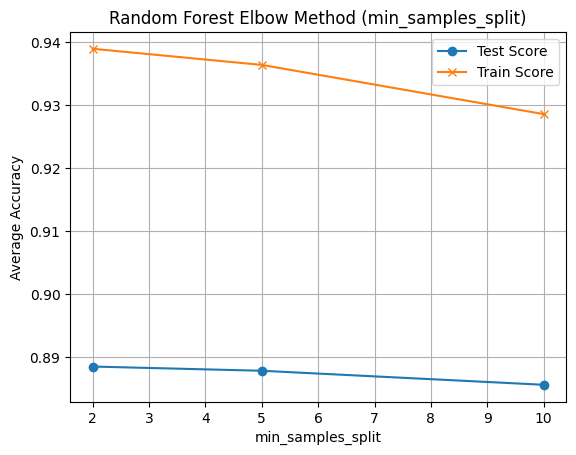

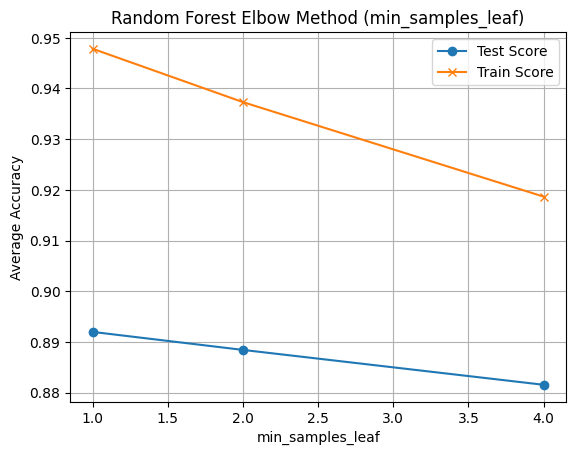

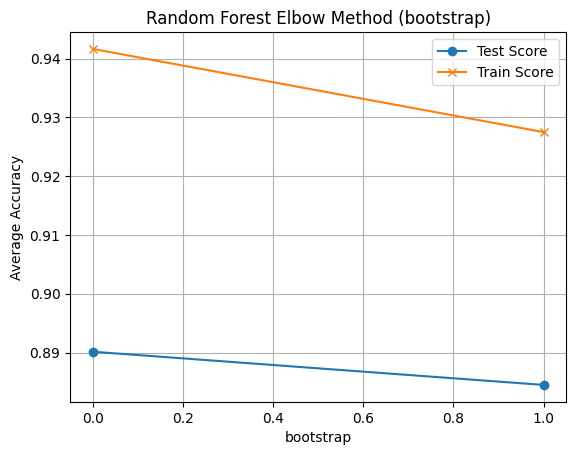

In [41]:
# Elbow method plot for Random Forest
rf_results = pd.DataFrame(rf_grid_search.cv_results_)
for param in rf_param_grid:
    avg_test_score = rf_results.groupby(f'param_{param}')['mean_test_score'].mean().reset_index()
    avg_train_score = rf_results.groupby(f'param_{param}')['mean_train_score'].mean().reset_index()
    plt.plot(avg_test_score[f'param_{param}'], avg_test_score['mean_test_score'], marker='o', label='Test Score')
    plt.plot(avg_train_score[f'param_{param}'], avg_train_score['mean_train_score'], marker='x', label='Train Score')
    plt.xlabel(param)
    plt.ylabel('Average Accuracy')
    plt.title(f'Random Forest Elbow Method ({param})')
    plt.legend()
    plt.grid(True)
    plt.show()

### Feature Importance

Feature Importance for Random Forest:


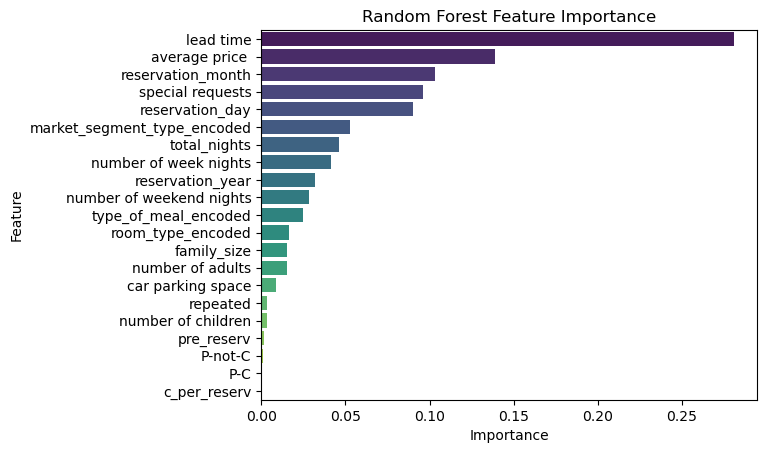

In [225]:
# Feature importance for Random Forest
rf_importances = rf_best_model.feature_importances_
rf_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importances
}).sort_values(by='Importance', ascending=False)
print("Feature Importance for Random Forest:")
ax = sns.barplot(x='Importance', y='Feature', hue='Feature', data=rf_feature_importance_df, palette='viridis')
plt.title('Random Forest Feature Importance')
plt.show()

best_acc['RandomForest'] = rf_accuracy_test * 100

## Accuracies Summary

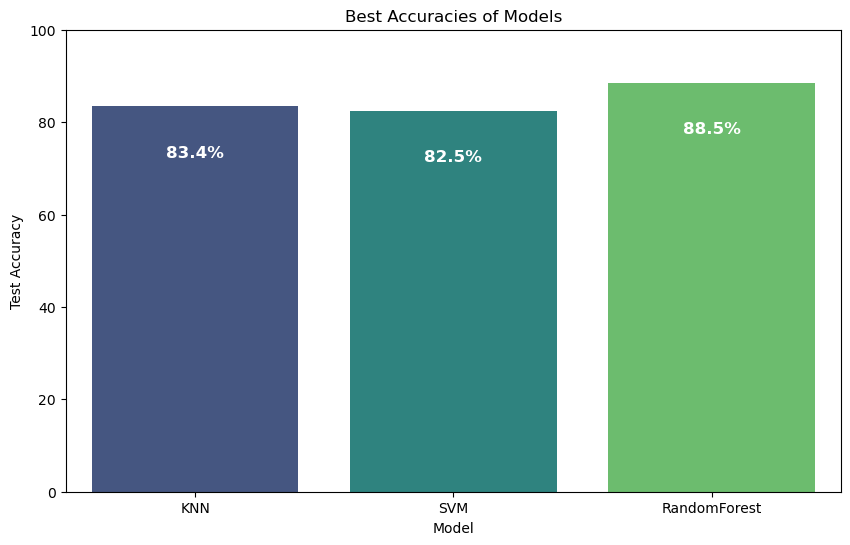

In [226]:
# Extract model names and accuracies
models = list(best_acc.keys())
accuracies = list(best_acc.values())

# Plot the accuracies
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=models, y=accuracies, hue=models, palette='viridis', dodge=False)
plt.xlabel('Model')
plt.ylabel('Test Accuracy')
plt.title('Best Accuracies of Models')
plt.ylim(0, 100)

# Annotate each bar with its value, positioned closer to the bars
for i, accuracy in enumerate(accuracies):
    plt.text(i, accuracy - 10, f'{accuracy:.1f}%', ha='center', va='center', color='white', fontsize=12, fontweight='bold')

plt.show()


# Model Deployment

In [ ]:
import pickle

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save the model to a .pkl file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf_best_model, file)